<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite Differences - Grid-Staggering Elastic 2D</div>
        </div>
    </div>
</div>

<p style="width:20%;float:right;padding-left:50px">
<img src=../../share/images/book.jpg>
<span style="font-size:smaller">
</span>
</p>


---

This notebook is a private extension writen by Yajian Gao based on part of the supplementary material 
to [Computational Seismology: A Practical Introduction](https://global.oup.com/academic/product/computational-seismology-9780198717416?cc=de&lang=en&#), 
Oxford University Press, 2016.


##### Authors:
* Ashim Rijal ([@ashimrijal](https://github.com/ashimrijal))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))
* Yajian Gao

This exercise covers the following aspects:

* Solving velocity-stress formulation of 2D wave equation with finite difference method
* Understanding the grid-staggering in connection with finite difference solution to the elastic wave equation
---

### Exercise
First understand the codes below and run the simulation. 

Then, improve the result using (4-point operator) for 1st derivative.

**Message: Once you become familiar with all the codes below you can go to the Cell tab on the toolbar and click Run All.**


In [1]:
# Configuration step (Please run it before the simulation code!)
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit
from matplotlib import cm


In [2]:
# Initialization of parameters

# Simple finite difference solver
# Elastic wave equation
# 2-D regular staggered grid

# Basic parameters
nt = 3000                                       # number of time steps
nx = 1000                                             # number of grid points in x
nz = 400
                                              # velocity (m/sec) (compression wave)
vp=np.zeros((nx,nz))+7000
vs=np.zeros((nx,nz))+5000
rho0=5000
irx=np.linspace(200,900,15)
irz=np.zeros(18)+(nz-3)

dx=1000                                          #m
dz=1000





isnap = 3                                              # snapshot frequency
isx = 200                                     # source location
isz = 200 


#####stable creterias
f0 =  np.max(vp)/dx/20
eps = 0.4
dt=eps*dx/np.max(vp)
dt_stable=dx/(7/6)/np.sqrt(2)/3000
print('f0=',f0)
print('dt=',dt)
print('dt_stable=',dt_stable)


nop = 10                                                # number of operator either 2 or 4


x = (np.arange(nx)*dx)                                 # initialize space coordinates 
z = (np.arange(nz)*dz)
                                     # calculate time step from stability criterion(s)



# Source time function
t = (np.arange(nt) * dt)                             # initialize time axis
T0 = 1. / f0                                           # period
a = 4. / T0                                            # half-width (so called sigma)
t0 = T0 / dt
tmp = np.zeros(nt)
for it in range(nt):
    t = (it - t0) * dt
    tmp[it] = -2 * a * t * np.exp(-(a * t) ** 2)       # derivative of Gaussian (so called sigma)
src = np.zeros(nt)                                     # source
src[0:len(tmp)] = tmp
lam = np.max(vp) * T0                                          # wavelength


#####source term in space
mxx=1e6/dx/dz
mzz=1e6/dx/dz






f0= 0.35
dt= 0.0571428571429
dt_stable= 0.20203050891


In [3]:
np.shape(z)

(400,)

In [4]:
np.shape(vp)

(1000, 400)

In [5]:
#####here we could add some heterosgenities in the velocity model
for i in np.arange(150,350):
        vp[i][i:i+60]=1.1*vp[i][i:i+60]
        
        
vp[:,350:400]=7000
        
   

In [6]:
x_coord=np.swapaxes(np.tile(x,(nz,1)),0,1)
print(x_coord)
z_coord=np.tile(z,(nx,1))
x_coord=np.reshape(x_coord,(nx*nz))
print(x_coord)
z_coord=np.reshape(z_coord,(nx*nz))
#print(z_coord)
xyz_matrix=np.zeros((2,nx*nz),dtype=float)
xyz_matrix[0]=x_coord
xyz_matrix[1]=z_coord


Vp=np.reshape(vp,(1,nx*nz))
Vs=np.reshape(vs,(1,nx*nz))
Velocity_matrix=np.zeros((2,nx*nz),dtype=float)
Velocity_matrix[0]=Vp
Velocity_matrix[1]=Vs

Vpv_smooth_all=np.zeros((2,nx*nz),dtype=float)



[[     0      0      0 ...,      0      0      0]
 [  1000   1000   1000 ...,   1000   1000   1000]
 [  2000   2000   2000 ...,   2000   2000   2000]
 ..., 
 [997000 997000 997000 ..., 997000 997000 997000]
 [998000 998000 998000 ..., 998000 998000 998000]
 [999000 999000 999000 ..., 999000 999000 999000]]
[     0      0      0 ..., 999000 999000 999000]


In [7]:
xyz_matrix

array([[      0.,       0.,       0., ...,  999000.,  999000.,  999000.],
       [      0.,    1000.,    2000., ...,  397000.,  398000.,  399000.]])

In [8]:
import numba
############################################################################################################
@numba.jit(nopython=True,parallel=True)
def smooth_new(xyz_matrix,iterations,sigmaxy,sigmaz,Velocity_matrix,Vpv_smooth_all):
        '''
        you still need to input a empty matrix input if you want to use this
        '''       
        for i in range(iterations):
            ###L2 difference between point i and the the position vector in x with sigma
            distance=(np.square(xyz_matrix[0][i]-xyz_matrix[0]))/(2*sigmaxy*sigmaxy)+\
                     (np.square(xyz_matrix[1][i]-xyz_matrix[1]))/(2*sigmaxy*sigmaz)
            distance=np.exp(-distance)
            distance= distance/np.sum(distance)
            Vpv_smooth_all[0][i] = np.dot(distance, Velocity_matrix[0])
            Vpv_smooth_all[1][i] = np.dot(distance, Velocity_matrix[1])
        return Vpv_smooth_all
        


In [ ]:
Vpv_smooth_all=smooth_new(xyz_matrix,nx*nz,10000,10000,Velocity_matrix,Vpv_smooth_all)

In [13]:
####this function is intended to use the cupy to accelerate the smoothing process provided you have installed cuda
#### of course you also need a nvidia graphic card
import cupy as cp
def smooth_cupy_new(xyz_matrix,iterations,sigmaxy,sigmaz,Velocity_matrix): 
      ##input a numpy array and using asarray move to the gpu device
      Velocity_matrix=cp.asarray(Velocity_matrix)
      xyz_matrix=cp.asarray(xyz_matrix)
      Vpv_smooth_all=cp.zeros((2,nx*nz),dtype=float)  
      #t1 = datetime.datetime.now()       
      for i in range(iterations):  
            distancex=(cp.square(xyz_matrix[0][i]-xyz_matrix[0]))/(2*sigmaxy*sigmaxy)
            #distancey=(cp.square(xyz_matrix[1][i]-xyz_matrix[1]))/(2*sigmaxy*sigmaxy)
            distancez=(cp.square(xyz_matrix[1][i]-xyz_matrix[1]))/(2*sigmaz*sigmaz)
            #print(distance)
            distance=distancex+distancez
            distance=cp.exp(-distance)
            distance= cp.divide(distance,cp.sum(distance))
            #print(distance)
            Vpv_smooth_all[0][i] = cp.dot(distance, Velocity_matrix[0])
            Vpv_smooth_all[1][i] = cp.dot(distance, Velocity_matrix[1])
      t2 = datetime.datetime.now() 
      #print(t2-t1)
      # move array from gpu device to the host
      return cp.asnumpy(Vpv_smooth_all)

In [ ]:
Vpv_smooth_all_cupy=smooth_cupy_new(xyz_matrix,nx*nz,10000,10000,Velocity_matrix)

In [11]:
vpv=Vpv_smooth_all[0].reshape(nx,nz)

<IPython.core.display.Javascript object>


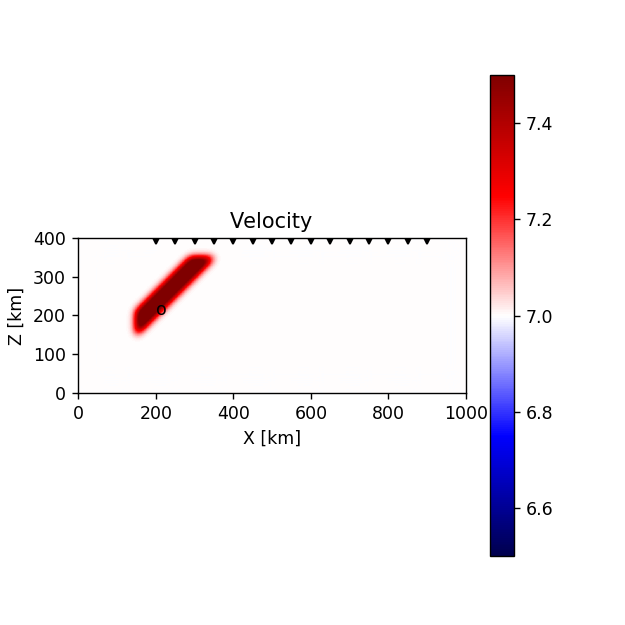

In [12]:
fig = plt.figure(figsize=(5,5))
image = plt.imshow(vpv.T/1000, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=6500/1000, vmax=7500/1000)
plt.colorbar()
plt.title('Velocity')  
plt.xlabel('X [km]')
plt.ylabel('Z [km]')
plt.gca().invert_yaxis()
plt.text(isx, isz, 'o')
for i in range(len(irx)):
    plt.plot(irx[i], irz[i], 'vk')
plt.ion()
plt.show(block=False)

In [29]:
np.shape(vp)

(1000, 400)

In [251]:
dx/(7/6)/np.sqrt(2)/3000

0.20203050891044214

In [13]:
@jit(nopython=True,parallel=True) # use JIT for C-performance
def update_v(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu):
    for i in range(ni1,ni2):
        for j in range(nk1, nk2):
            dsxx =  9/8*(sxx[i+1][j]-sxx[i][j])/(dx)-1/24*(sxx[i+2][j]-sxx[i-1][j])/(dx)
            dszx = 9/8*(szx[i][j]-szx[i-1][j])/(dz)-1/24*(szx[i+1][j]-szx[i-2][j])/(dx)
            dszz = 9/8*(szz[i][j+1]-szz[i][j])/(dz)-1/24*(szz[i][j+2]-szz[i][j-1])/(dx)
            dsxz = 9/8*(sxz[i][j]-sxz[i][j-1])/(dx)-1/24*(sxz[i][j+1]-sxz[i][j-2])/(dx)
            vx_new=(dsxx+dsxz)
            vz_new=(dszz+dszx)
            vx[i,j]=vx[i][j]+dt*(vx_new/rho[i,j]) 
            vz[i,j]=vz[i][j]+dt*(vz_new/rho[i,j])
    return vx,vz



<IPython.core.display.Javascript object>


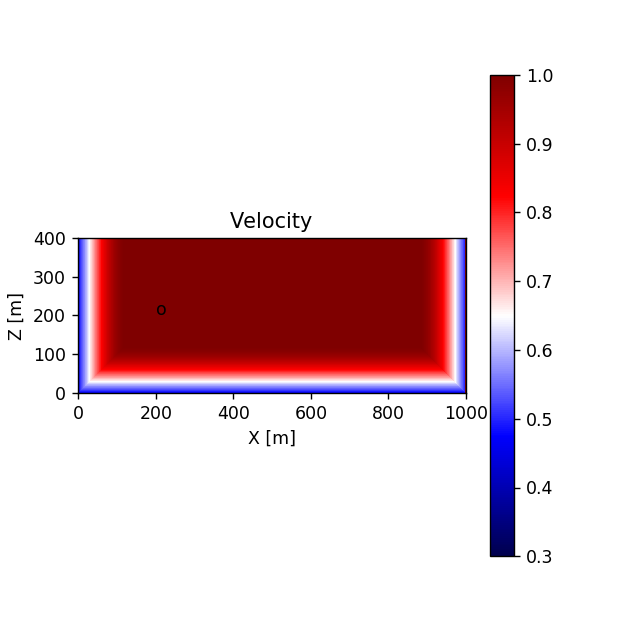

In [14]:

def generate_damp_guassian(nx,nz,ni1,ni2,nk1,nk2,absorb_thickness_n):
    #absorbpoint_x=np.arange(ni1,ni1+absorb_thickness_n-1)
    damp=np.ones((nx,nz))
    ####left boundary
    for i in range(ni1,ni2):
        for j in range(0,absorb_thickness_n):
            #print()
            damp[i,j]=(np.exp(-(0.007*(ni1+absorb_thickness_n-j))**2))
            
            
    #lower boundary
    for i in range(nk1,absorb_thickness_n):
        for j in range(0,nk2):
            #print()
            damp[i,j]=(np.exp(-(0.007*(nk1+absorb_thickness_n-i))**2))
            #print(j,damp[i,j])   
    # right boundary       
    for i in range(ni2-absorb_thickness_n,ni2):
        for j in range(0,nz):
            #print()
            damp[i,j]=(np.exp(-(0.007*(ni2-absorb_thickness_n-i))**2))
            #print(j,damp[i,j])    
    # left lower corner 
    for j in range(0,nk1+absorb_thickness_n):
        damp[j:ni1+absorb_thickness_n,j]=(np.exp(-(0.007*(nk1+absorb_thickness_n-j))**2))
                
    # right lower corner
    for j in range(0,nk1+absorb_thickness_n):
        damp[ni2-absorb_thickness_n:ni2-j,j]=(np.exp(-(0.007*(nk1+absorb_thickness_n-j))**2))   
    
            
    return damp


stencil=2
ni1=stencil+1
ni2=nx-stencil
nk1=stencil+1
nk2=nz-stencil
damp=generate_damp_guassian(nx,nz,ni1,ni2,nk1,nk2,120)
fig = plt.figure(figsize=(5,5))
image = plt.imshow(damp.T, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=0.3, vmax=1)
plt.colorbar()
plt.title('Velocity')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.gca().invert_yaxis()
plt.text(isx, isz, 'o')
plt.ion()
plt.show(block=False)    
    
    
    
    
    

In [15]:
damp

array([[ 0.47648406,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.47648406,  0.48223873,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.47648406,  0.48223873,  0.48801507, ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 0.47648406,  0.49962923,  0.49962923, ...,  0.49962923,
         0.49962923,  0.49962923],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [16]:
@jit(nopython=True,parallel=True) # use JIT for C-performance
def update_s(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu):
    for i in range (ni1, ni2):
        for j in range(nk1, nk2-1):
            ezx=9/8*(vz[i+1,j]-vz[i,j])/dx-1/24*(vz[i+2][j]-vz[i-1][j])/dx
            exz=9/8*(vx[i,j+1]-vx[i,j])/dz-1/24*(vx[i][j+2]-vx[i][j-1])/dz
            exx=9/8*(vx[i,j]-vx[i-1,j])/dx-1/24*(vx[i+1,j]-vx[i-2,j])/dx
            ezz=9/8*(vz[i,j]-vz[i,j-1])/dz-1/24*(vz[i,j+1]-vz[i,j-2])/dz
            #hTxx=(lamd[i,j]+2*mu[i,j])*exx+lamd[i,j]*ezz
            #hTzz=(lamd[i,j]+2*mu[i,j])*ezz+lamd[i,j]*exx
            #hTxz=(mu[i,j])*ezx+(mu[i,j])*exz
            sxx[i,j]=sxx[i,j]+((lamd[i,j]+2*mu[i,j])*exx+lamd[i,j]*ezz)*dt
            sxz[i,j]=sxz[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt
            szz[i,j]=szz[i,j]+((lamd[i,j]+2*mu[i,j])*ezz+lamd[i,j]*exx)*dt
            szx[i,j]=szx[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt
        ### free surface
        sxx[:,nk2]=sxx[:,nk2]+((lamd[:,nk2]+2*mu[:,nk2])*exx-(lamd[:,nk2]**2/(lamd[:,nk2]+2*mu[:,nk2])*exx))*dt
            #sxz[i,j]=sxz[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt
        szz[:,nk2]=szz[:,nk2]
            #szx[i,j]=szx[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt                
    return sxx,sxz,szz,szx

In [17]:

import datetime

######here you could input a heterogenity vp and vs

def assemble_psv(dx,dz,rho0,vp,vs,dt,nt,nx,nz,irx,irz,isx,isz,src,damp):
    t1 = datetime.datetime.now() 
    rho=np.zeros((nx,nz))+rho0
    mu = np.zeros((nx,nz))+rho*vs**2
    lamd=np.zeros((nx,nz))+rho*vp**2-2*mu
    ##### initial the cycle
    vx = np.zeros((nx, nz))
    vz = np.zeros((nx, nz))
    sxx = np.zeros((nx, nz)) 
    sxz = np.zeros((nx, nz))
    szz = np.zeros((nx, nz))
    szx=np.zeros((nx, nz))
    seis = np.zeros((len(irx), nt))
    print(np.shape(seis))
    ir = np.arange(len(irx))
    v = max([np.abs(src.min()), np.abs(src.max())])
    stencil=2
    ni1=stencil+1
    ni2=nx-stencil
    nk1=stencil+1
    nk2=nz-stencil
    fig = plt.figure(figsize=(6,6))
    #extent = [np.min(),np.max(X),np.min(X),np.max(Y)]
    image = plt.imshow(vz.T, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=-1e-3, vmax=1e-3)
    #image = plt.imshow(vp.T/100000, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=-0.001, vmax=0.001)
    plt.colorbar()
    plt.title('Wavefield vy')
    plt.xlabel('X [km]')
    plt.ylabel('Y [km]')
    plt.gca().invert_yaxis()
    plt.text(isx, isz, 'o')
    plt.ion()
    plt.show(block=False)
    #### free surface by image
    #plt.text(isx, isz, 'o')
    for i in range(len(irx)):
        plt.plot(irx[i], irz[i], 'vk')
    #fig.canvas.draw()
      
    for it in np.arange (nt):
        szz[:,nk2]=0
        #for n in range(0,stencil-1):
        #    szz[:,nk2+1+n]=-szz[:,nk2-1-n]
         #   sxz[:,nk2+n]=-sxz[:,nk2-n-1]
        vx, vz = update_v(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu)
        vx=vx*damp
        vz=vz*damp
        vz[:,nk2  :nz]  = 0.0;
        vx[:,nk2+1:nz]  = 0.0;
        vz[isx,isz]=vz[isx,isz]+src[it] 
        vx[isx,isz]=vx[isx,isz]+src[it] 
        ###for the receivers
        for k in np.arange(len(irx)):
            print(vz[int(irx[k]),int(irz[k])])
            seis[k,it]=seis[k,it]+vz[int(irx[k]),int(irz[k])]
        sxx,sxz,szz,szx = update_s(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu)
        #sxx=sxx*damp
        #sxz=sxz*damp
        #szz=szz*damp
        #szx=szx*damp
        if (it % isnap) == 0:
            #print(np.shape(vz))
            image.set_data(vz.T)
            plt.plot
            fig.canvas.draw()
    t2 = datetime.datetime.now()   
    print(t2-t1)
    return vx, vz,seis








(15, 3000)


<IPython.core.display.Javascript object>


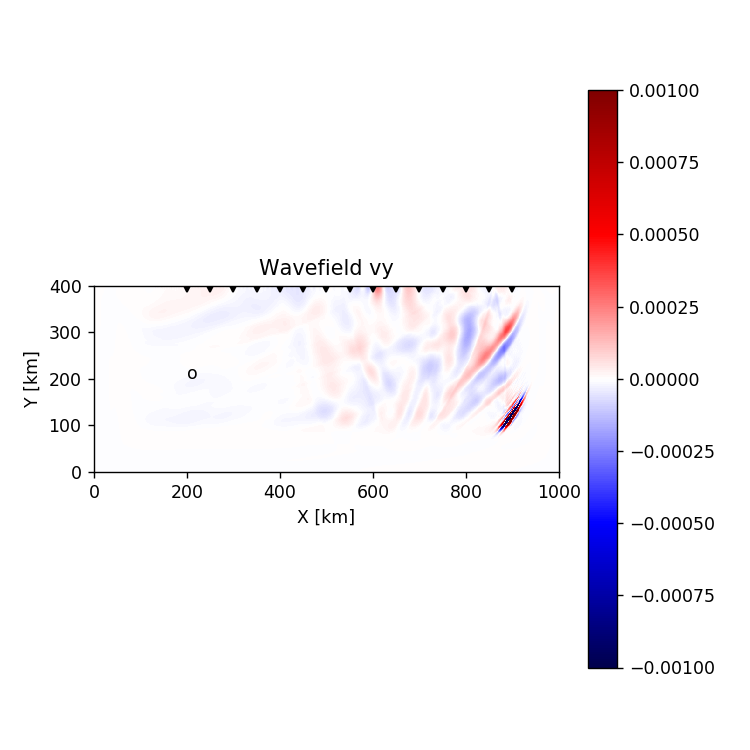

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


-2.35753669382e-143
4.15205285448e-180
3.95343812088e-260
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.38215377956e-142
-2.80097135922e-178
-3.79767030623e-257
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.94259331853e-141
1.72759458549e-176
3.09727603442e-254
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.56337767095e-141
-9.75782593683e-175
-2.16461964051e-251
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.59022826884e-140
5.05412229703e-173
1.30708723929e-248
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.82867935767e-139
-2.40345958101e-171
-6.87004704411e-246
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.09904225999e-139
1.05040387286e-169
3.16401917883e-243
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.15749774419e-137
-4.22226272617e-168
-1.28457422631e-240
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.6537280551e-137
1.56189490786e-166
4.62270704428e-238
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.48301912793e-136
-5.31894108118e-165
-1

8.2695339439e-99
-2.92927547388e-112
7.8954667532e-146
-2.30066357211e-196
-1.43350155867e-268
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.5269381475e-98
5.92393478841e-112
-7.17451962329e-146
5.71202968376e-195
1.29154762738e-266
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.10997082252e-99
6.11205492587e-111
-3.07334086965e-144
-1.34387614379e-193
-1.10157642301e-264
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.02095198017e-97
-1.04172709289e-110
2.59535487976e-143
2.99446392443e-192
8.90140597341e-263
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.07889907435e-96
-1.24487553916e-109
-4.87292433513e-143
-6.3148601674e-191
-6.81978997463e-261
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.87346895023e-97
1.50825741856e-109
-7.84140448031e-142
1.25924137362e-189
4.95749133569e-259
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.80807336985e-96
2.45221558875e-108
7.11987740285e-141
-2.37179211524e-188
-3.42155698686e-257
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.26275250551e-95
-1.43313376061e-108
-1.184623

4.28167408687e-72
-1.47437693066e-80
2.83665020034e-105
1.10484725266e-144
3.82544206937e-193
1.06626722702e-249
3.45845952089e-322
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.8945152784e-72
8.84221346809e-80
-2.83200273662e-104
6.02208255782e-143
6.0354973819e-191
-2.10364995975e-248
-1.7460279924e-320
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.27947219585e-71
3.52239716242e-79
-6.19915689632e-104
-2.15804697053e-142
-6.13137132476e-190
3.96395491596e-247
8.97573999456e-319
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.24956536485e-70
8.63817936331e-80
4.52567990464e-103
-1.1795409416e-141
2.72168557717e-189
-7.12712391889e-246
-4.42283020753e-317
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.55082077015e-70
-2.90108709866e-78
1.29754808038e-102
9.63456035306e-141
5.97427630737e-189
1.22132563949e-244
2.09436615983e-315
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.81738746852e-70
-8.07720842893e-78
-6.75265647112e-102
8.82728587757e-141
-1.8866992465e-187
-1.9919611409e-243
-9.53260253516e-314
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.011883

-1.30474158889e-52
2.96500401158e-58
-1.41169941108e-76
8.14067723107e-110
1.29120946275e-152
-2.94884728702e-202
-4.7007975644e-257
-6.04708188768e-318
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.66077657246e-52
4.64662068514e-58
-5.24593684148e-76
-6.79006585667e-109
1.89402875177e-151
1.232952806e-201
3.33094944102e-256
1.15568174849e-316
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.81953561252e-52
-3.38847785996e-58
3.56565347972e-76
-1.78232770088e-108
-6.01953297883e-151
5.0106775354e-201
-1.03416705365e-255
-2.12123076687e-315
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6397209906e-52
-3.67902952124e-57
5.79283708422e-75
9.55244756087e-108
-3.84810908756e-150
-7.11416181265e-200
-7.85847534921e-255
3.73608955999e-314
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.24539081446e-51
-9.00750764433e-57
8.08254659038e-75
3.54664998315e-107
1.97984616855e-149
1.53071116482e-199
1.44436583355e-253
-6.30784374609e-313
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.20038481183e-51
-5.95671331733e-57
-3.89520455361e-74
-1.21215633923e-106
6.84259754498e-149
1.90

-2.19744387829e-37
-6.55419003569e-42
-6.31916952598e-56
-6.30660049212e-84
3.6017536542e-121
-1.16861854707e-167
-5.63729017848e-218
-4.01244664895e-272
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.644162393e-37
-3.3159896187e-41
-1.7527887359e-54
3.0236242518e-82
1.24309978276e-120
-1.5237255631e-166
5.42022192102e-218
6.50448880378e-272
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.55435173074e-39
-7.21056012652e-41
-3.83185409947e-54
6.15721606061e-82
-4.4798595501e-120
3.47383110323e-166
1.61142721782e-216
1.36910847653e-270
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.70796199734e-37
-7.67405045404e-41
1.797973659e-54
-1.98655647074e-81
-2.30753638544e-119
3.15116937651e-165
-6.23713593644e-216
-1.18997922434e-269
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.02946047192e-36
7.30230468361e-41
2.83778860324e-53
-9.96221225537e-81
4.65661865096e-119
-9.0426448304e-165
-3.24538512693e-215
1.6113343946e-269
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.83232826142e-36
5.42411748115e-40
5.78416943193e-53
1.60133951973e-81
3.91898025969e-118
-6.3804689644e-164

4.95338843728e-26
-4.0615020625e-29
-1.61308695375e-38
-1.57375391904e-61
4.74445240889e-97
-1.17693720881e-139
-1.02764958159e-186
1.9365105719e-237
-6.71307826849e-291
0.0
0.0
0.0
0.0
0.0
0.0
2.00529572773e-25
-2.49184015142e-28
-4.2462233478e-38
-3.3425105415e-61
1.60319858893e-95
-3.20456427317e-138
8.25471067391e-186
-1.08870650751e-236
4.66616107876e-290
0.0
0.0
0.0
0.0
0.0
0.0
4.39672917243e-25
-5.92749643137e-28
-3.73833170556e-38
4.07203934884e-61
2.32165700794e-95
-1.60752695623e-138
2.05056824335e-185
-3.43925574628e-236
4.77237126791e-290
0.0
0.0
0.0
0.0
0.0
0.0
6.93407873766e-25
-9.09679564046e-28
9.21180880253e-38
3.35270247608e-60
-1.30720752223e-94
4.59754138503e-137
-1.67270345605e-184
3.57395275146e-235
-1.96294794044e-288
0.0
0.0
0.0
0.0
0.0
0.0
7.3439090813e-25
-7.1464220308e-28
4.03047570175e-37
4.60243427714e-60
-4.8188160085e-94
7.43022707968e-137
-4.15507327969e-184
3.5105154648e-235
6.51274610104e-288
0.0
0.0
0.0
0.0
0.0
0.0
1.19139035429e-25
8.71265317194e-28


7.76152352931e-18
2.32283369242e-19
5.03745962365e-26
-2.50082152287e-45
1.3048106297e-75
-1.67151799087e-115
-1.17323010015e-160
1.20437535047e-208
-9.1574298545e-260
-2.66177988346e-312
0.0
0.0
0.0
0.0
0.0
-6.83874225437e-17
-6.49518576714e-19
5.45476880678e-26
2.33498996226e-44
1.06843742519e-76
-4.71743053755e-115
7.27339528824e-160
-2.26758293075e-208
1.06072343929e-258
4.80258742613e-312
0.0
0.0
0.0
0.0
0.0
-2.02796104795e-16
-2.37381177914e-18
-2.44329302714e-26
6.95623055004e-44
-1.03616912647e-74
1.02043989618e-114
2.595193257e-159
-2.40809829985e-207
1.18858888777e-258
7.5929682501e-311
0.0
0.0
0.0
0.0
0.0
-3.90636946518e-16
-4.85700644296e-18
-2.44404027562e-25
4.0416971478e-44
-2.33179932915e-74
7.04587685317e-114
-7.55464465243e-159
3.64219279645e-207
-2.83355090323e-257
-3.99467569417e-310
0.0
0.0
0.0
0.0
0.0
-5.90635372074e-16
-7.3098984993e-18
-5.61291881196e-25
-2.76803399952e-43
3.23580378438e-74
1.50685919705e-114
-4.70865234843e-158
4.74460001944e-206
-1.87916075292

3.46397042871e-10
-1.56207672676e-11
-1.18144700469e-16
-1.81964287149e-31
-8.69814752324e-58
1.23378704089e-96
-7.41664996231e-138
5.79970511379e-183
-1.634123839e-231
9.45183726526e-282
0.0
0.0
0.0
0.0
0.0
1.38893791925e-10
-2.31907011024e-11
4.55552893973e-17
-3.45172662706e-30
9.95414013146e-58
3.60148750427e-94
1.68145696725e-136
2.46630771366e-182
-1.4350305532e-230
-4.54743100732e-281
0.0
0.0
0.0
0.0
0.0
-3.84388738254e-10
-2.79603231062e-11
4.01928392045e-16
-7.63112876344e-30
7.76375821765e-57
7.67288285616e-94
3.91987722046e-136
-5.16646572948e-182
2.26872505593e-230
-2.02894714712e-280
0.0
0.0
0.0
0.0
0.0
-1.39114025444e-09
-2.53725576215e-11
9.10004552553e-16
-4.69126505474e-30
1.20558109909e-56
-1.40752356744e-93
-1.15738817855e-135
-4.2644536555e-181
2.81415841229e-229
1.20879028092e-279
0.0
0.0
0.0
0.0
0.0
-3.06288192676e-09
-9.54984235149e-12
1.34758200252e-15
1.89082700722e-29
-1.95277510026e-56
-9.55932937217e-93
-6.50817714117e-135
1.60527588702e-181
-2.47346166029e-

-0.000653339880621
-5.12135589604e-05
1.788822617e-10
-4.26101300585e-20
3.92801021395e-43
2.06771793466e-77
-2.09500426554e-117
8.93632459461e-162
-7.58320147279e-208
3.27167200926e-256
-1.3571237793e-306
0.0
0.0
0.0
0.0
-0.000747332484449
-7.60359688831e-05
2.36316937046e-10
2.91100866759e-20
2.59746585908e-44
6.2827542837e-77
-3.36976016727e-117
-1.29885674391e-160
-9.46904809452e-207
4.61116016339e-255
2.72183510993e-305
0.0
0.0
0.0
0.0
-0.000835549486023
-0.000108650462115
2.59021578572e-10
1.93496975278e-19
-1.86872344499e-42
5.48428887534e-78
1.15074003733e-116
-3.48125917116e-160
-2.30842411217e-207
-2.79616879917e-255
2.38108969034e-305
0.0
0.0
0.0
0.0
-0.000912383100244
-0.000150218316592
2.14231241248e-10
3.72161156831e-19
-4.6271032759e-42
-4.16051356645e-76
5.5272428701e-116
8.30033295368e-160
1.35141976731e-205
-8.76018187982e-254
-6.46558089192e-304
0.0
0.0
0.0
0.0
-0.000971830015544
-0.000201670165004
5.85559134195e-11
3.21094320849e-19
-2.07040388301e-42
-1.01636053082

-0.000230019614787
0.000638124065781
-0.000352821880781
3.05179327695e-13
1.4683814124e-30
-7.66967689291e-62
-6.735153754e-100
3.05236663012e-141
-1.65093412086e-185
-2.95650348229e-232
-1.33368142689e-281
0.0
0.0
0.0
0.0
-0.000240912951428
0.000491951088014
-0.000410797065403
-1.57524996524e-12
1.47157300136e-30
-7.54323758765e-62
1.82352277217e-99
6.52932585567e-141
1.80326329519e-185
2.51060823985e-231
-1.54839357212e-279
0.0
0.0
0.0
0.0
-0.000243421085816
0.000355131445848
-0.000467378323215
-3.96934787453e-12
-2.09144449161e-30
2.41577612662e-61
9.27478481977e-99
-1.41252718707e-140
2.31070294597e-184
8.15748275167e-231
-1.07059684075e-279
0.0
0.0
0.0
0.0
-0.000239494305115
0.00023131036513
-0.000519441809644
-5.6876492999e-12
-1.05889600331e-29
1.00622931464e-60
8.81731728249e-99
-9.25442597981e-140
2.38261437475e-184
-2.47921281011e-230
2.76617985197e-278
0.0
0.0
0.0
0.0
-0.000230863859266
0.000122864969384
-0.000563565909789
-5.11610184594e-12
-1.74259449108e-29
1.13210705854e

-1.9948326007e-05
-3.19576899274e-05
5.99179638519e-05
2.44358084264e-08
4.97805029167e-21
1.20906814632e-49
6.28202819234e-85
-1.87055943201e-124
-1.11679630421e-167
-9.31686125335e-212
-4.01764515399e-258
9.76007819795e-307
0.0
0.0
0.0
-1.8968414582e-05
-2.97384171804e-05
2.89391004723e-05
5.3940827902e-08
5.26141881248e-21
-4.72426499855e-49
2.58707311438e-84
1.53714629868e-124
2.64477722093e-166
-6.9394907753e-211
-1.18992527814e-257
-1.25694773116e-306
0.0
0.0
0.0
-1.80577651611e-05
-2.77054320813e-05
4.45941710531e-06
9.93692059586e-08
-2.31711019281e-21
-1.72039993042e-48
2.59721566673e-84
1.85137283265e-123
7.06179597122e-166
-2.04830779399e-211
4.33315910765e-257
-1.92526371697e-305
0.0
0.0
0.0
-1.72099131123e-05
-2.58455743701e-05
-1.41277973381e-05
1.62053278593e-07
-2.04912172367e-20
-2.11092964857e-48
-9.31895025241e-84
3.29104012301e-123
-1.02718121315e-165
8.13556763446e-210
2.47672987564e-256
7.43950759293e-306
0.0
0.0
0.0
-1.64191437849e-05
-2.41503240871e-05
-2.754991

-5.2146277907e-06
-8.49348767052e-06
-8.02539764147e-06
-3.64428700377e-05
-4.67752916334e-14
-5.02436448561e-38
-2.59572302251e-71
5.73014757065e-109
-2.09093643137e-149
-2.20110410505e-192
2.02264428627e-237
-4.35578239907e-285
0.0
0.0
0.0
-5.06711003204e-06
-8.1365936221e-06
-8.11838691443e-06
4.75951896841e-05
-6.18686249436e-14
-8.64435381252e-38
2.15375807355e-71
2.30893055492e-108
-4.51549437881e-149
-2.37405226406e-192
-1.08148466484e-237
-7.0206624276e-284
0.0
0.0
0.0
-4.92709895147e-06
-7.82309988808e-06
-8.25256803285e-06
0.000132285779118
-3.9934766447e-14
-2.61162145977e-38
1.90029275734e-70
2.04078307513e-108
6.65183785276e-149
1.76766445375e-191
-2.81832034557e-236
-2.95165579304e-284
0.0
0.0
0.0
-4.79617632964e-06
-7.55909525193e-06
-8.43922859836e-06
0.00021386479561
3.2932064963e-14
2.56455369959e-37
3.76614805263e-70
-1.02813537691e-107
5.44875593699e-148
6.48258653225e-191
-4.18674442558e-236
1.05794782674e-282
0.0
0.0
0.0
-4.67674794211e-06
-7.35068879771e-06
-8.69

-9.43518431866e-07
5.37642022985e-06
1.06188798034e-05
-3.97707066646e-05
-2.59170596915e-11
1.7371817601e-29
7.68437827606e-59
-2.80343951971e-95
4.96201236662e-134
-1.71718082065e-175
-9.91986739035e-219
1.66212549138e-263
-5.17337229901e-310
0.0
0.0
-3.6652776859e-08
4.98303105409e-06
9.53663564064e-06
-2.89015279766e-05
-1.12383813852e-10
-2.09566312145e-28
9.08530933419e-59
3.95190572898e-94
8.31521516696e-133
-3.95045191136e-174
-1.86101571834e-217
-1.04704055657e-263
4.57318654201e-310
0.0
0.0
7.41577815977e-07
4.38530502263e-06
8.13517389995e-06
-1.95637266725e-05
-2.58159957946e-10
-5.66213221794e-28
-1.03372127629e-58
1.20757520994e-93
1.79176591371e-132
-8.21419872335e-174
-3.12226631814e-217
-2.4612206354e-262
9.19524543493e-309
0.0
0.0
1.38120461333e-06
3.62826247574e-06
6.50393710467e-06
-1.17456698387e-05
-4.67758065725e-10
-7.5663729822e-28
-6.70586961314e-58
9.02853449346e-94
-1.41370934904e-132
1.50649676881e-173
1.33950766327e-216
-3.17968231928e-262
7.10009246615e-3

-2.61685226525e-06
-9.86147940654e-06
-5.29991252598e-06
4.26043419272e-05
-3.90191689793e-05
2.10192035091e-21
-1.06062914753e-48
8.32248285352e-83
-1.46149712636e-120
1.74618345854e-159
-3.26633067771e-201
1.27941229055e-245
-1.39341492331e-290
0.0
0.0
-2.87198944149e-06
-9.48966576782e-06
-5.2510149737e-06
3.66818104109e-05
-4.5556113846e-05
-3.00892878972e-22
-4.59272327026e-49
7.12603256727e-82
-5.12087577432e-119
-3.27333309416e-159
-4.03512156587e-202
1.22055187115e-244
3.60191407959e-290
0.0
0.0
-3.07816864647e-06
-8.86773814121e-06
-5.1990965223e-06
3.11426484067e-05
-5.22018630516e-05
-5.89151783769e-21
2.88085549756e-48
1.49212243049e-81
-1.27672016661e-118
-2.23797418018e-158
3.08075402658e-200
1.13625870637e-244
2.668378915e-289
0.0
0.0
-3.24085572857e-06
-7.99830691531e-06
-5.13843161543e-06
2.60916315149e-05
-5.87412574924e-05
-1.34324044059e-20
9.33407567503e-48
3.80873194044e-82
-1.26251903754e-119
-3.2693087049e-158
7.95350079691e-200
-1.2057930067e-243
1.13549623601e

1.67923104929e-05
-4.73493629845e-06
-1.93562930231e-06
-8.93006078529e-06
1.57241540626e-05
-1.55962603277e-15
8.71239049948e-40
-6.54851031853e-71
-2.08545651206e-106
-1.50198679754e-145
-2.59980631149e-185
1.42343401291e-228
-4.17141904591e-272
6.77533959031e-318
0.0
2.01421452034e-05
-5.52570641269e-06
-2.31487664021e-06
-8.87279515727e-06
1.29511086244e-05
-1.67408047472e-15
3.53790351172e-39
-5.21965191557e-71
-3.84688309364e-106
1.57743253844e-144
-4.24105050954e-186
-2.21580380232e-227
-2.16048924828e-271
1.05522145386e-317
0.0
2.36722773874e-05
-6.12581339306e-06
-2.69728546861e-06
-8.7826862425e-06
8.65871403412e-06
-9.07770640953e-16
6.3640326627e-39
1.55376766473e-70
1.44964045363e-106
5.36350088864e-144
2.13762285091e-184
-6.83045865109e-227
4.02727862116e-272
-7.84646007665e-317
0.0
2.73144446162e-05
-6.39709459291e-06
-3.07088092046e-06
-8.66453402889e-06
2.76908795967e-06
1.04164370457e-15
4.87120043972e-39
6.59227587452e-70
2.596883978e-105
3.50222345408e-144
5.8641075

-2.33389153481e-05
9.76221257876e-05
2.27512354917e-07
-3.95480075481e-06
0.0002052046755
8.6647405171e-12
-9.70042216742e-32
1.98973556942e-60
-2.35283336585e-94
3.98633583548e-131
-1.54384248853e-170
-1.3025079379e-211
8.60375768883e-255
5.08689893368e-300
0.0
-2.27087851243e-05
-1.36207532504e-05
5.33919798289e-07
-3.86556230628e-06
0.000189577601597
1.50107410215e-11
2.51873671803e-31
2.24123463622e-60
-6.62228612786e-94
4.42723332812e-131
-9.37473552351e-170
-7.03823432254e-211
8.55589429975e-254
1.27451440174e-298
0.0
-2.17598550456e-05
-0.000130939044555
8.65359174467e-07
-3.77974922027e-06
0.000171214959549
2.28734286945e-11
9.38988033947e-31
-1.92442439518e-60
-6.28608497443e-94
-1.32489534006e-130
-1.28883899953e-169
-5.83998304644e-211
1.11046067804e-253
2.09154016886e-298
0.0
-2.05897355015e-05
-0.000249921428938
1.22196591079e-06
-3.69723139612e-06
0.00015092739097
3.0577471373e-11
1.71000622211e-30
-1.43022640835e-59
1.64086210786e-93
-6.55061878884e-130
3.80421289439e-16

8.64053940634e-06
4.72261379996e-05
-5.36071945869e-07
-2.34580164866e-06
-1.86325874238e-05
-2.75292427171e-06
6.307846122e-25
1.97527760513e-51
6.40728701773e-83
3.30020786723e-118
4.41398238991e-156
2.66991613477e-196
1.36950959592e-237
-4.98910613727e-282
0.0
9.73461132945e-06
4.12284588727e-05
-3.80459900598e-06
-2.43169055905e-06
-1.72707968386e-05
-3.88052564072e-06
-4.46237164029e-24
-8.9888598352e-51
5.38280708861e-83
-2.76097728797e-119
1.75020855203e-155
-2.0387565732e-195
2.18880633505e-237
-7.9559571468e-281
0.0
1.08327131767e-05
3.89592728306e-05
-6.55898564913e-06
-2.53842670687e-06
-1.60301339015e-05
-5.30058089129e-06
-1.2964191616e-23
-3.16870252028e-50
-1.44296912626e-82
-1.99789792403e-117
1.65855761124e-155
-7.64795131281e-195
-7.72900505843e-237
-1.31000549335e-280
0.0
1.19106812934e-05
3.93990970438e-05
-8.29866615861e-06
-2.66460542997e-06
-1.49033399142e-05
-7.04487800384e-06
-2.1899062192e-23
-5.40918560964e-50
-6.51751309579e-82
-5.45876865975e-117
-7.6629577

1.53258827165e-05
8.42394358757e-06
-2.77973746896e-05
1.6632231383e-05
-4.24186424694e-06
-0.000101453742093
1.5765161154e-18
2.08930292784e-43
3.38743237244e-73
-5.96516609636e-107
-4.09406733069e-144
-1.40067100347e-182
-3.21584045574e-223
6.96565779253e-266
1.21700521608e-310
1.5039349096e-05
8.38735601704e-06
-0.00014815944715
1.70853577855e-05
-4.12740359493e-06
-0.000109543867939
1.08211960555e-18
1.53559638417e-42
3.33993440518e-73
-4.49899435731e-107
2.72946781922e-143
-8.62631884852e-182
-1.20238860142e-222
1.21553165704e-265
-2.62398648824e-310
1.47306669161e-05
8.81840859586e-06
-0.000268373883601
1.69291520308e-05
-4.02150075918e-06
-0.000118630415669
-6.85104106519e-19
3.47990414795e-42
-4.97741734046e-73
1.88947547513e-106
1.01209767456e-142
-1.29796734079e-181
-3.48343235294e-223
-4.05265710466e-265
-2.03468665322e-309
1.43960093495e-05
9.54355611147e-06
-0.000383157243796
1.61019195731e-05
-3.92357842882e-06
-0.000128396506081
-3.97484258198e-18
4.43892728384e-42
-2.83

-2.84585271201e-06
1.26619621526e-06
8.54046746642e-05
-3.59934282478e-07
-2.10701824194e-06
0.000320392872655
-3.23363911347e-14
1.99466995475e-35
3.5752243111e-64
1.28534736127e-96
-7.136944398e-132
-1.61266027878e-171
-2.6959012142e-209
-4.4822974722e-251
7.67042637091e-295
-3.45214123223e-06
1.94951692065e-06
7.89012731104e-05
6.04939795915e-07
-2.06429858577e-06
0.000282951455379
-2.95238304001e-14
9.18140830235e-36
1.228616992e-63
4.96856937002e-96
-2.53038990691e-131
-5.41895695473e-169
5.39106653341e-210
-9.02859342016e-251
2.77105328083e-294
-4.04372450081e-06
2.62139242419e-06
7.34227812454e-05
1.27933720422e-06
-2.02421958142e-06
0.000241676957273
-1.51655011278e-14
-3.38143580451e-35
2.05868627371e-63
7.67186675734e-96
-2.89183843809e-131
-1.49631779771e-168
2.29889565318e-208
1.78426460764e-250
-1.3567315339e-294
-4.62181827701e-06
3.20598413149e-06
6.86846483401e-05
1.69648070681e-06
-1.9864949324e-06
0.000198288824905
1.29897521616e-14
-1.17526603181e-34
9.68744572499e-6

-1.40733856514e-05
8.42457958714e-06
7.49978454422e-06
8.29707653759e-07
-1.00652950522e-06
-3.0180723647e-05
-2.77188094294e-10
5.45242216104e-29
-3.00767801055e-55
2.02688862959e-86
1.02403538488e-120
4.79912711797e-157
-4.48929588969e-196
1.63394427383e-238
-1.21625924158e-279
-1.4082349242e-05
8.35784024443e-06
7.17135922132e-06
3.26224486096e-07
-9.13959489213e-07
-2.66441225434e-05
-6.36379150644e-10
-4.57456037417e-29
-4.19884443687e-55
3.15965603548e-86
4.48012666531e-120
7.07316728021e-157
2.44300082029e-196
1.90553800454e-236
-2.49034756191e-279
-1.40675564432e-05
8.2273124469e-06
6.76185318269e-06
-2.24768812567e-07
-8.17520130541e-07
-2.35367582269e-05
-1.15143269168e-09
-2.66776247339e-28
-8.61042630117e-56
-1.73948897352e-87
7.15320684925e-120
-1.02736344648e-156
3.95489982527e-195
4.9926972272e-236
5.34766761503e-279
-1.40320066201e-05
8.05795563037e-06
6.22877736421e-06
-7.77749209341e-07
-7.20612027873e-07
-2.08214805892e-05
-1.81246720263e-09
-5.87795862001e-28
1.2638

-9.48977229192e-06
4.41782366778e-06
5.12079195083e-06
0.000153450718567
-1.59777082718e-06
-2.88988508282e-06
-1.20730660288e-05
1.53914068976e-22
3.17069006745e-47
5.41434730848e-77
7.35420948011e-110
-2.42788826607e-145
-2.76664028399e-183
1.97519739133e-223
1.98396897629e-265
-8.94826499722e-06
4.27213625564e-06
4.77960620037e-06
0.000110204110861
-1.55560222177e-06
-2.78832208357e-06
-1.53808394429e-05
1.72727926026e-22
4.5853993932e-47
8.90764506846e-77
-1.60951834641e-110
-1.54861008639e-145
-5.74953762129e-183
8.24255775573e-223
1.20381065049e-264
-8.3551458124e-06
4.16719071546e-06
4.43179277672e-06
6.0317255606e-05
-1.51177865968e-06
-2.69452106875e-06
-1.92578890771e-05
8.14635562264e-23
2.22069188516e-47
2.45200271161e-77
-4.10439104611e-109
9.65240319717e-145
2.341466104e-183
7.51882255692e-223
1.46095891496e-264
-7.71468907816e-06
4.09784966475e-06
4.10609059066e-06
5.67437342453e-06
-1.46766950577e-06
-2.60776353176e-06
-2.37610018817e-05
-1.97062456865e-22
-8.7483724929

-4.66938943659e-06
1.56747087688e-06
1.13335597985e-06
4.9606155335e-05
-6.13424777884e-07
-1.56611676926e-06
7.20180873863e-05
-1.05138334071e-17
-2.4437919601e-40
1.36722372241e-68
2.66799647603e-100
4.05152016871e-134
3.01443399937e-171
1.00448933731e-210
3.47980474073e-251
-4.49259342086e-06
1.23438423968e-06
1.25954666028e-06
4.93612254185e-05
-5.98996138889e-07
-1.55200424315e-06
0.000133739875623
7.62656005488e-19
-9.98089931225e-40
9.3699770765e-68
-2.12292077928e-99
8.01237775652e-134
-1.54662371828e-171
9.02009525001e-210
3.5717779333e-251
-4.25845484114e-06
8.87688138946e-07
1.40828771126e-06
4.81768272682e-05
-5.85273952728e-07
-1.53798127203e-06
0.000194497618239
2.27920522937e-17
-1.93501633026e-39
2.09271584737e-67
-7.28882877101e-99
1.3146264649e-134
-2.30854456643e-170
1.82694149255e-209
-1.84378523361e-250
-3.98114752392e-06
5.36046919085e-07
1.57197966237e-06
4.6303255899e-05
-5.71866688898e-07
-1.52380096249e-06
0.000251892028692
5.38518729481e-17
-2.23890817298e-39

-4.54456357413e-07
-4.60050830258e-06
7.70898415518e-06
5.44356191201e-06
-9.95490698131e-07
-1.09498658423e-06
-0.00011131335587
5.87332099156e-14
-2.50234881592e-33
-1.60699566841e-59
4.60747409456e-90
9.49059355068e-124
-1.35518907122e-159
-1.1482533035e-197
8.62700362423e-238
-4.36368646897e-07
-4.75467270053e-06
7.80144278645e-06
5.13257273745e-06
-9.37791432045e-07
-1.08395071764e-06
-0.000108421464332
3.68058360603e-14
-2.93379714179e-33
-3.70957562999e-59
-2.73058697827e-90
-1.9272846902e-123
5.05024287909e-160
-7.12396641833e-198
7.31595776288e-238
-4.20802023061e-07
-4.93099869935e-06
7.8751322734e-06
4.84845351311e-06
-8.61575303372e-07
-1.07304783592e-06
-0.000104014630055
3.37889442329e-15
-8.57872516199e-34
-4.66866003837e-59
-2.73791500067e-89
-1.02810589302e-122
9.24160744264e-159
5.51796751575e-197
-4.41072298087e-237
-4.07472517962e-07
-5.13915256313e-06
7.92749223387e-06
4.59405340117e-06
-7.69274964987e-07
-1.06219209167e-06
-9.84917340012e-05
-2.03134081639e-14
5.5

8.96538874129e-07
-3.47429264335e-06
5.16235001813e-06
3.18646793099e-06
-1.77333479586e-07
-1.01896963409e-06
-4.09253134592e-06
-3.04407977246e-09
-4.19964018838e-27
8.43340236346e-52
1.04156173294e-80
3.01608842369e-114
2.70009452698e-148
7.9647166013e-186
5.19880254331e-225
9.91071785196e-07
-3.21268870199e-06
5.0861744083e-06
3.23573805644e-06
-1.63036789257e-07
-1.03531705215e-06
-3.70995197615e-06
-5.00334284531e-09
-9.35783128668e-28
3.4505931122e-51
2.457382577e-80
-5.47920307662e-113
5.2848862942e-148
-1.1605275026e-185
1.78769982947e-224
1.0866662149e-06
-3.04227472669e-06
4.98614109634e-06
3.27683035225e-06
-1.56677604489e-07
-1.04775296037e-06
-3.38160590484e-06
-7.47259799899e-09
8.50071998171e-27
6.83656961068e-51
2.90557489245e-80
-1.726659912e-112
9.26863704757e-149
-8.23995868434e-185
1.50344306882e-224
1.18295192604e-06
-2.95585281585e-06
4.85682437435e-06
3.30766837484e-06
-1.71930126105e-07
-1.0555143406e-06
-3.0988918703e-06
-1.02854589713e-08
2.50036253491e-26
7.

1.88412315747e-06
-5.59916038445e-06
-8.14859368757e-06
2.81533385645e-06
-9.62470829006e-06
-6.1643931111e-07
-9.23645435639e-07
-6.72945751287e-05
-3.58266140633e-21
6.56893489051e-44
-6.9417947444e-72
1.48372767432e-103
9.94632869528e-138
-4.71305324889e-174
-1.71010489372e-212
1.7784316023e-06
-5.60280440284e-06
-5.95309791419e-06
2.84001891767e-06
-4.75565977736e-06
-6.06366959043e-07
-9.0519138015e-07
-8.53925907628e-05
-7.20420710603e-21
7.11110912472e-44
-9.95359924747e-72
-4.65107626409e-104
-4.46442740392e-138
-1.26217233876e-174
-9.21432847409e-213
1.66478268953e-06
-5.60246403701e-06
-3.5014698733e-06
2.8666923922e-06
3.27894519888e-07
-5.95954245912e-07
-8.88157177447e-07
-0.000105504017097
-1.04389554887e-20
-2.85095324573e-45
-2.76705196535e-72
-7.77862215924e-103
-6.28589977078e-137
2.32622643462e-173
8.4128060985e-212
1.54392034031e-06
-5.59936488678e-06
-8.78817141944e-07
2.89351574619e-06
5.43528907592e-06
-5.85183236444e-07
-8.72421728842e-07
-0.000127086086544
-1.0

-2.56720251237e-06
-9.62437004705e-06
-5.33461826588e-06
5.01311887863e-06
-4.63554361292e-07
-3.35732472733e-07
-7.05347705835e-07
0.000307706946295
2.36401003438e-16
5.29883300213e-37
1.24221728479e-63
4.00924029099e-94
1.61875299582e-127
5.71603123005e-163
1.50680212765e-200
-2.68995707795e-06
-9.31660296676e-06
-5.56371622222e-06
4.68039933197e-06
-9.04757021401e-07
-3.29906535426e-07
-7.04090820259e-07
0.000280019934462
5.19012907836e-16
3.78027542818e-37
2.41952830838e-63
1.06802411743e-93
-1.71743123653e-127
1.90731351569e-162
2.90203132819e-201
-2.8079256138e-06
-8.86709949485e-06
-5.75493149009e-06
4.22928859401e-06
-1.18900635933e-06
-3.2459311234e-07
-7.02651614869e-07
0.000248097794793
8.21588435343e-16
-4.48322294939e-37
2.57585026282e-63
1.46502743458e-93
-1.26506602063e-126
2.55896270676e-162
-8.29862929807e-200
-2.9213751227e-06
-8.27256466367e-06
-5.92205149906e-06
3.64302969949e-06
-1.33484456839e-06
-3.2003601237e-07
-7.00966849974e-07
0.000213418029487
1.01964343893

-8.1556017965e-06
3.06451146271e-06
-7.3059127051e-06
1.61667916285e-05
2.52294948249e-06
-2.44066739328e-07
-6.03118737424e-07
-3.91192609763e-05
3.84851049594e-12
1.62885411031e-30
2.10103078038e-56
-4.74009850795e-85
2.35302368666e-117
4.80176125311e-152
-6.4914636214e-189
-8.46719355773e-06
2.86423983658e-06
-7.27560471621e-06
2.24319637544e-05
2.49817219111e-06
-2.04819877298e-07
-5.99933323833e-07
-3.56868071301e-05
5.9330926561e-12
2.48519400863e-30
-7.42869285425e-56
-7.3239855176e-85
2.54043142789e-117
6.78521879553e-152
-1.22307084456e-188
-8.72820594514e-06
2.70565235797e-06
-7.23934223898e-06
2.82669267873e-05
2.47010755935e-06
-1.67612649808e-07
-5.969028232e-07
-3.24658050905e-05
8.04405517728e-12
2.47363113309e-30
-2.76025429493e-55
-3.05584861392e-85
-2.94692640154e-117
-4.13933109483e-152
7.59164935672e-190
-8.92727348055e-06
2.58409159816e-06
-7.19853572281e-06
3.34473809209e-05
2.43930410643e-06
-1.33739611363e-07
-5.94141509843e-07
-2.94572225175e-05
9.60254880888e-

-6.99809850269e-06
3.04373220605e-06
-5.87511539372e-06
-1.22602693259e-05
1.63108617368e-06
-3.99666700801e-07
-8.30158312312e-07
-1.31649355595e-06
-9.27852154386e-08
-6.20881704745e-25
-1.35188712828e-48
1.60886837298e-76
1.56398115487e-108
1.15775617744e-141
-3.17242261993e-178
-7.1626034477e-06
3.05341985248e-06
-5.81352305119e-06
-1.30449753157e-05
1.61814881697e-06
-4.07886543305e-07
-8.11744170712e-07
-1.21312843491e-06
-1.10930639019e-07
-7.61420025366e-26
-3.93899801557e-48
2.98767126049e-76
1.35127319283e-107
1.71199344864e-141
1.21079350907e-177
-7.30251115812e-06
3.06067708888e-06
-5.74586985401e-06
-1.35895974998e-05
1.60239852859e-06
-3.97415041344e-07
-7.89902642914e-07
-1.12480834381e-06
-1.15906683081e-07
1.24070973283e-24
-6.89048671678e-48
2.80922348441e-76
3.31646498288e-107
-4.31006719086e-142
5.32915585944e-177
-7.41393944855e-06
3.06498999014e-06
-5.67259232274e-06
-1.3885967502e-05
1.58341879718e-06
-3.57956863508e-07
-7.65302442024e-07
-1.04907271363e-06
-9.60

-4.62956263742e-06
1.78648953509e-06
1.51984234868e-06
-2.5044474176e-06
-5.14840521132e-07
-0.000152337790011
-3.96291126331e-07
-3.78818280746e-07
-0.00017800398821
9.61305713641e-20
-9.84571142439e-42
-3.3084222239e-69
-8.62893629386e-99
7.73358967054e-132
1.76167133921e-167
-4.67809575683e-06
1.69247670494e-06
2.53781642409e-06
-2.51750833029e-06
-7.81593113708e-07
-0.000165666400759
-3.94226853291e-07
-3.71541856507e-07
-0.000184816437506
2.87552357235e-20
-3.16732809725e-41
-3.29296565063e-68
-2.24368619211e-98
2.54597054528e-131
1.30980790788e-166
-4.72825469114e-06
1.59506983428e-06
3.55428482095e-06
-2.54079214424e-06
-1.05874578182e-06
-0.000175617156621
-3.92270318341e-07
-3.65035977685e-07
-0.000185875049823
-1.26984810897e-19
-5.93643951245e-41
-8.28935154181e-68
-3.16835835997e-98
4.08894389017e-131
3.03491217475e-166
-4.76760922851e-06
1.49449902363e-06
4.52571150278e-06
-2.57190286989e-06
-1.33460636288e-06
-0.000181261347352
-3.90420536002e-07
-3.59251292558e-07
-0.000

1.27605808487e-05
-2.01628236273e-06
-1.16759672203e-05
-2.53671167103e-06
1.0143039475e-05
7.96534779303e-05
-3.78336941221e-07
-3.22382426162e-07
3.32531709091e-05
-3.56228232319e-15
3.54260883134e-35
-1.39852338625e-60
4.64353041034e-90
-4.59261694622e-122
1.16862109534e-157
1.28090566432e-05
-2.14992636422e-06
-1.03677198896e-05
-2.54389741938e-06
9.47606213104e-06
6.46423269988e-05
-3.77569454286e-07
-3.22532000311e-07
1.371837562e-05
-5.72753119987e-15
4.83520067792e-37
-2.35599711857e-60
1.32394384493e-89
-2.39294846474e-122
3.12995787072e-156
1.27963483596e-05
-2.28065385374e-06
-9.03271450762e-06
-2.56043319843e-06
8.73384158557e-06
5.06771913026e-05
-3.76867880997e-07
-3.22620275025e-07
-3.29272009756e-06
-7.52719689303e-15
-9.0590073864e-35
-2.21792243968e-60
2.12883201781e-89
1.25445939012e-121
8.85753191796e-156
1.27400503946e-05
-2.40787754423e-06
-7.71548633006e-06
-2.58541542017e-06
7.95072171168e-06
3.78135690646e-05
-3.76328426864e-07
-3.22624157386e-07
-1.77139200686

8.88053193922e-06
-4.17606874095e-06
2.45170109044e-06
-3.0908694273e-06
1.89453371432e-06
-4.5876815735e-06
-2.86297223317e-07
-2.88997277782e-07
-1.54819588322e-05
5.79175032646e-12
3.16393395516e-29
-3.38697574426e-53
3.04371915497e-82
3.2277579892e-113
-1.93927532782e-146
8.54349680041e-06
-4.18811938197e-06
2.41197798926e-06
-3.08633041493e-06
1.71493315547e-06
-3.8180948076e-06
-2.66774101226e-07
-2.87347103226e-07
-1.43343193039e-05
-1.59823749725e-11
8.46540631695e-29
-4.28482514514e-53
-1.74777187089e-81
-1.04730935873e-112
-6.85788661341e-147
8.19214593324e-06
-4.19858723249e-06
2.382346176e-06
-3.08100925884e-06
1.51206698397e-06
-3.21113732924e-06
-2.49328671938e-07
-2.86303856811e-07
-1.32499791385e-05
-5.33100284007e-11
1.48371669219e-28
-1.85865009838e-53
-6.14984422649e-81
-4.42160776458e-112
6.85182629892e-146
7.82844127804e-06
-4.2068658689e-06
2.36398174323e-06
-3.07549168643e-06
1.29128063447e-06
-2.74117513856e-06
-2.34617418913e-07
-2.86175606742e-07
-1.2221341420

-7.3584104881e-07
5.46229024131e-06
3.54719620903e-06
-3.83390951893e-06
-8.41949335379e-07
3.78479206428e-06
-4.99482659376e-07
-4.79958623738e-07
-4.85501359381e-07
1.43521279065e-07
-1.01426659283e-23
-3.08623223124e-46
-2.14499718368e-73
-3.5360130645e-104
-7.186477158e-137
-9.21140351443e-07
6.1647013332e-06
3.55466444734e-06
-3.84110217494e-06
-9.25949121566e-07
3.86103174089e-06
-5.0571097321e-07
-4.46576187134e-07
-4.53706456233e-07
3.84700898777e-07
-2.30035035334e-23
-5.18622213513e-46
-3.71123692198e-73
8.77746669287e-104
-3.02070982599e-136
-1.10038983305e-06
6.71583790709e-06
3.56401245367e-06
-3.84849759383e-06
-1.01952304668e-06
3.92701067788e-06
-5.11015798782e-07
-4.12061039542e-07
-4.30327465376e-07
7.2003180659e-07
-3.72362879481e-23
-5.67233761721e-46
-3.49960938927e-73
3.96282488827e-103
-5.94560663721e-136
-1.27444892544e-06
7.07410155515e-06
3.57622589438e-06
-3.85694052193e-06
-1.12164728941e-06
3.98362921136e-06
-5.15318070852e-07
-3.77281819325e-07
-4.13777850

-6.43684383862e-06
-4.53089064051e-06
3.79208635588e-06
-4.04971664016e-06
-4.22775862684e-06
4.23216530531e-06
1.1469819859e-06
-1.29265007433e-07
-2.31227217644e-07
-9.44860658454e-05
-4.34503229561e-19
-2.58109823426e-41
-1.02888967183e-65
4.55667939927e-95
4.2622797507e-127
-6.64720315966e-06
-3.580975353e-06
3.69436983869e-06
-4.0425118068e-06
-4.3062263223e-06
4.34713883253e-06
1.81881796842e-06
-1.33745081493e-07
-2.20381677607e-07
-7.1752164871e-05
1.25344618664e-19
-1.07449144246e-39
-8.61769372154e-66
3.53373215609e-95
8.62497585155e-127
-6.85205986495e-06
-2.74992976617e-06
3.59765894299e-06
-4.03325259464e-06
-4.38102337445e-06
4.48021298277e-06
2.58347855188e-06
-1.38515061949e-07
-2.10103268599e-07
-4.52354347323e-05
1.17559963046e-18
-2.86638431589e-39
8.0719090908e-66
-6.36511893805e-95
8.10989633384e-127
-7.05030268334e-06
-2.04669332842e-06
3.50501082064e-06
-4.02123352632e-06
-4.45207102435e-06
4.62725557487e-06
3.39689526861e-06
-1.43629064707e-07
-2.00459994132e-07

-7.23892029979e-06
-3.00230389442e-06
2.94519040621e-06
-4.11175226253e-06
-4.89753051437e-06
2.4386684927e-06
-0.00021195002381
-3.36640930969e-07
-1.49824514358e-07
-2.72358129159e-05
1.85605874816e-15
1.40290183199e-33
-2.36753217149e-58
-7.09241101215e-87
-6.39945414881e-118
-7.03604378593e-06
-3.17981040051e-06
2.92233712186e-06
-4.13372261768e-06
-4.85993779448e-06
2.23259821754e-06
-0.000186433814072
-3.49541535905e-07
-1.50558256718e-07
-3.19308880063e-05
1.13868686379e-14
2.48889913661e-33
-1.90859231942e-58
-2.09263071419e-86
-1.23289649869e-117
-6.8217397583e-06
-3.36035017632e-06
2.90023811679e-06
-4.12868628825e-06
-4.8189206644e-06
2.0321743521e-06
-0.00015414937894
-3.63619117667e-07
-1.51160735072e-07
-3.53331479581e-05
2.51271950891e-14
3.22504646838e-33
1.72383610185e-58
-3.6337170668e-86
-1.13991858653e-117
-6.59676708687e-06
-3.54307834202e-06
2.87878324194e-06
-4.09382343301e-06
-4.77467644338e-06
1.83772072542e-06
-0.000115895386398
-3.78787420696e-07
-1.516208383

7.02403942191e-08
-5.57134851528e-06
2.31808010843e-06
-1.20727099787e-07
-2.88504045856e-06
-3.04673173824e-06
-3.04602266266e-05
-7.78311022714e-07
-1.33223526834e-07
-8.45071307345e-06
-2.66469550665e-10
-7.023145526e-28
-2.82234043383e-51
-1.18812997753e-78
3.02473813247e-109
4.74032913657e-07
-5.60734687406e-06
2.24227632262e-06
1.17636289239e-07
-2.80531106154e-06
-3.24761724662e-06
-4.27789602615e-05
-7.84628834172e-07
-1.3301504733e-07
-7.96236693762e-06
-3.54211186105e-10
-1.07795743651e-27
-4.29076299433e-51
-1.51629336897e-78
9.44801419309e-109
9.22381791448e-07
-5.64612450049e-06
2.15287117183e-06
3.72928712712e-07
-2.72646078601e-06
-3.43888939535e-06
-5.13787369599e-05
-7.91010343362e-07
-1.33825028756e-07
-7.48543863456e-06
-4.13302786751e-10
-1.2303890708e-27
-3.96651851412e-51
-4.38050118649e-79
1.66254724678e-108
1.41325762449e-06
-5.68578658746e-06
2.04866220099e-06
6.42074758113e-07
-2.64866207185e-06
-3.61848549732e-06
-5.64346878643e-05
-7.97611037231e-07
-1.36045

-5.6698828511e-06
-3.56774172207e-06
-1.41840409763e-06
4.84384627344e-06
-1.1742784237e-06
-5.17828435233e-06
-1.50681730569e-06
-9.55503599534e-07
-2.35352502744e-07
1.49312585508e-08
1.49801367757e-06
5.58759986017e-23
-7.34956835819e-46
-5.0649097781e-71
9.79526732816e-101
-5.54251276732e-06
-3.33148348899e-06
-1.43214798949e-06
4.92279134565e-06
-1.14307379215e-06
-5.18366836725e-06
-1.61065984262e-06
-9.50268236202e-07
-1.96297833186e-07
2.0819413121e-08
1.97250284873e-06
1.3122090938e-22
-1.20420279254e-44
-3.84626996578e-71
-4.10803680394e-101
-5.22992625478e-06
-3.08318289673e-06
-1.45679482814e-06
5.00437337183e-06
-1.11257121089e-06
-5.18497709154e-06
-1.57174573626e-06
-9.43702856244e-07
-1.58244098048e-07
1.86417697245e-08
2.4210588353e-06
2.19553687981e-22
-3.12425782702e-44
5.01110365188e-71
-4.77491267965e-100
-4.75446104531e-06
-2.82372251899e-06
-1.49464349991e-06
5.0880660909e-06
-1.08253545637e-06
-5.18214061458e-06
-1.40022152952e-06
-9.35780145268e-07
-1.220778634

5.25035843288e-06
5.83453753788e-06
-4.56011625708e-06
5.72993102682e-06
-4.40571813695e-07
-3.82153150973e-06
-2.04230404045e-07
7.87908646405e-07
1.65651716474e-09
-2.71389750644e-07
1.13229385926e-05
3.84546119845e-18
2.00640508431e-38
-1.34900259157e-63
-2.34906841936e-92
5.1374430979e-06
6.12557107707e-06
-4.69336363225e-06
5.59280430239e-06
-4.22544196683e-07
-3.74273971382e-06
-2.92954588964e-07
1.01743674048e-06
-1.19904910519e-08
-2.57840145252e-07
3.36010769144e-05
4.06903607366e-18
3.58577780691e-38
-1.42337721069e-63
-6.3245898919e-92
5.00998099492e-06
6.40835482323e-06
-4.8229058564e-06
5.43134559997e-06
-4.05115345911e-07
-3.66323592922e-06
-3.80999431926e-07
1.25973269063e-06
-2.72496880416e-08
-2.43613919228e-07
5.52442254119e-05
2.81637149313e-18
4.67345687362e-38
1.96128533868e-65
-1.0431969604e-91
4.87053107716e-06
6.6822997472e-06
-4.94797535003e-06
5.24506030003e-06
-3.88297393713e-07
-3.58311908188e-06
-4.75203915488e-07
1.51146920608e-06
-4.40301225817e-08
-2.289

3.19831027038e-06
9.49341295099e-06
-6.76166630006e-06
5.20950142494e-07
-1.5058139419e-07
-1.59553819749e-06
-4.16786706553e-06
1.25005339842e-05
-6.55877379188e-07
-5.06501635925e-08
-2.55610193013e-05
5.51275723417e-14
-1.57369327339e-32
-1.42559351862e-56
-3.25376678327e-84
3.34078234404e-06
9.424950501e-06
-6.76313769324e-06
4.44363069955e-07
-1.47749551127e-07
-1.54085030603e-06
-4.26382116536e-06
1.42740053977e-05
-6.74718238385e-07
-5.28601398748e-08
-2.63917992171e-05
7.30110650845e-14
-2.33206775223e-32
-2.72977229844e-56
-5.0559779988e-84
3.48869334809e-06
9.34625822116e-06
-6.75882627721e-06
3.50415288371e-07
-1.43793129914e-07
-1.48799699494e-06
-4.34962492675e-06
1.62148614963e-05
-6.92751467865e-07
-5.51308622913e-08
-2.67211261931e-05
8.33533319667e-14
-2.50024850246e-32
-3.59650033608e-56
-3.94446547607e-84
3.63920888047e-06
9.25769937671e-06
-6.74841997378e-06
2.39705001484e-07
-1.38875500002e-07
-1.43696876865e-06
-4.42394687934e-06
1.82547717168e-05
-7.09933616107e-

2.12945461253e-06
3.69410294469e-06
-4.47119066543e-06
-3.08120451982e-06
-1.57188669146e-07
-7.09035799375e-07
-4.51941176829e-06
-0.000279339711872
-7.35591747868e-07
-5.28895924008e-08
-5.59745866167e-06
-3.97201075931e-10
3.21582274987e-27
3.2741384795e-50
-1.57439751792e-76
1.88381261249e-06
3.43018983864e-06
-4.34559885087e-06
-3.15704190754e-06
-1.6146505912e-07
-7.20711049935e-07
-4.47601422646e-06
-0.000248298818935
-7.19397756228e-07
-5.3062247966e-08
-5.34319542481e-06
-2.17927414212e-10
6.05021172897e-27
-2.33353698028e-50
-2.16347391277e-76
1.6436937656e-06
3.17209155206e-06
-4.2204209983e-06
-3.22691190715e-06
-1.6562243309e-07
-7.36815441245e-07
-4.42875591408e-06
-0.000207406066534
-7.02704766148e-07
-5.45767073887e-08
-5.09009233387e-06
1.65095403076e-10
8.73311842585e-27
-1.54079623917e-49
-1.26009247626e-76
1.41193798159e-06
2.92099127605e-06
-4.09589811488e-06
-3.29101861785e-06
-1.69845246596e-07
-7.56861180486e-07
-4.37696196234e-06
-0.000157567318564
-6.856764418

6.29830868693e-07
-2.3547345756e-07
-1.81674053588e-06
-2.95353532982e-06
-2.77734006183e-06
1.03061729749e-07
-2.03656158505e-06
-4.32668609994e-05
-1.64336936547e-07
4.13536574037e-09
3.61753542074e-07
2.28493793861e-06
1.60228251896e-22
1.15760081514e-43
-3.63600455725e-69
6.03808113514e-07
-2.10841398178e-07
-1.79552633907e-06
-2.87858989962e-06
-2.82603870163e-06
1.41061984744e-07
-1.96389231245e-06
-3.94461222298e-05
-5.06230415816e-08
5.31413857328e-08
3.71505635326e-07
2.45316767055e-06
2.92759579299e-24
2.92831510867e-43
-6.49097398225e-69
5.76613074882e-07
-1.78303594124e-07
-1.77984432404e-06
-2.79997714799e-06
-2.83375345983e-06
1.76570301799e-07
-1.89341518155e-06
-3.32959570095e-05
8.77493602845e-08
9.86758321539e-08
3.71959792602e-07
2.37526874824e-06
-3.19550021898e-22
5.04756959169e-43
-7.56708098619e-69
5.52537667158e-07
-1.39051483685e-07
-1.76965536069e-06
-2.71796061059e-06
-2.7994344571e-06
2.10775425746e-07
-1.82561302881e-06
-2.60663028943e-05
2.5186672986e-07
1

-1.1053849692e-06
9.14399000099e-08
-2.6656744048e-06
3.10840779106e-07
-1.06055296974e-06
1.54122375203e-06
-6.42489535881e-07
-8.38059312998e-06
4.90738538532e-06
-2.78820783802e-07
-3.5251936221e-07
4.94122968432e-05
-2.11243362643e-18
-1.69368815837e-37
-1.1947410963e-62
-1.18159412864e-06
6.6370480807e-09
-2.6966234446e-06
4.36280655047e-07
-1.01421338115e-06
1.58115040615e-06
-6.15964528583e-07
-7.55502957828e-06
4.90420855311e-06
-3.11178312638e-07
-3.49361666469e-07
6.27836032738e-05
-7.85290154043e-18
-3.14648446248e-37
-6.00796595489e-62
-1.22937548922e-06
-8.7927011815e-08
-2.72448582206e-06
5.60937554002e-07
-9.63327290174e-07
1.61899564342e-06
-5.90118220118e-07
-6.92140075066e-06
4.90084923871e-06
-3.43130762667e-07
-3.43675829055e-07
7.43139912164e-05
-1.57659731778e-17
-4.37369919639e-37
-1.35672579241e-61
-1.24821235237e-06
-1.93318710874e-07
-2.74898517564e-06
6.8452158935e-07
-9.10890750618e-07
1.65491035781e-06
-5.65094166874e-07
-6.46952625761e-06
4.89862472659e-06

6.95443584469e-07
-1.81628700707e-07
-1.53526929236e-06
3.1164153142e-06
4.08304150897e-07
1.78365356069e-06
-2.37327482825e-07
-4.63092343963e-06
4.91766514675e-06
-7.76795796911e-07
1.53213941695e-08
-1.82644071636e-05
9.35408373294e-14
5.39034954472e-32
2.75694851028e-55
5.51978279228e-07
9.27133493462e-08
-1.41818587808e-06
3.16377550377e-06
4.48921566187e-07
1.71879603682e-06
-2.45493302275e-07
-4.47061240318e-06
4.91549510344e-06
-7.68250819486e-07
1.62369823328e-08
-1.83176610216e-05
7.43021651172e-14
1.19413968922e-31
3.13632983765e-55
3.91670312213e-07
3.43425990263e-07
-1.2968201976e-06
3.20757495684e-06
4.87039266736e-07
1.65059122819e-06
-2.60014597838e-07
-4.32163160116e-06
4.91871673088e-06
-7.5798434689e-07
1.62372738155e-08
-1.81474648985e-05
1.41725998273e-14
1.93454487139e-31
1.17882208572e-55
2.17121178659e-07
5.66685921481e-07
-1.17128306787e-06
3.24770292017e-06
5.22890195529e-07
1.58049772556e-06
-2.82180857549e-07
-4.18581728056e-06
4.92784720948e-06
-7.460555242

-8.66102726151e-07
5.31282767462e-07
3.31214168795e-06
2.68964090522e-06
1.65428009834e-06
-1.30895530037e-06
-1.60323504714e-06
-1.44710136568e-06
1.27259337652e-06
-1.46385933523e-07
-5.57093434415e-09
-4.17814659329e-06
1.79724447382e-10
4.71515417534e-27
-2.08878116934e-49
-6.86750807122e-07
3.98549966072e-07
3.50659679464e-06
2.61006457802e-06
1.68819050201e-06
-1.61939353388e-06
-1.5302854467e-06
-1.38419323555e-06
1.26728673386e-06
-1.29610449925e-07
7.01153038238e-09
-4.02507681411e-06
8.17927040692e-10
-2.5523763539e-27
4.05379296375e-49
-5.09331280856e-07
2.57479934716e-07
3.70580225678e-06
2.52691810943e-06
1.72002029206e-06
-1.93068966083e-06
-1.45708053237e-06
-1.32300444983e-06
1.47120590267e-06
-1.12583254955e-07
2.11427964388e-08
-3.87346099204e-06
1.7414943167e-09
-1.67460490738e-26
1.66992468599e-48
-3.36989348673e-07
1.0913398677e-07
3.91049287477e-06
2.44029132194e-06
1.74990080247e-06
-2.23625877038e-06
-1.38486703004e-06
-1.26190714511e-06
1.92822923051e-06
-9.419

-1.56295095124e-06
-2.25707395596e-06
1.14285741071e-05
-9.62337198607e-07
2.18824759406e-06
-4.67874513855e-06
5.5139690096e-07
-7.13835671417e-08
-0.000292477257787
4.08036508403e-06
1.8427492459e-07
5.15967824009e-07
2.06948655317e-06
-6.42248417427e-22
-2.38905545775e-43
-1.7459530981e-06
-2.20936128508e-06
1.17620367917e-05
-1.10912912649e-06
2.18782063434e-06
-4.72393777528e-06
6.29761794647e-07
-5.27122993502e-08
-0.000311327067108
4.23025680633e-06
1.88992032924e-07
5.47018855258e-07
1.85014700507e-06
-1.11082152406e-21
-1.24778885178e-42
-1.91557810012e-06
-2.14964126167e-06
1.20913960228e-05
-1.25521453943e-06
2.18590827048e-06
-4.76526439976e-06
7.07181658451e-07
-3.55430824701e-08
-0.000323452606855
4.36718387493e-06
1.89544456124e-07
5.68332223347e-07
1.28942148427e-06
-1.55019126723e-21
-2.80736039891e-42
-2.06784989332e-06
-2.07796360442e-06
1.24135365971e-05
-1.40034370623e-06
2.1825670149e-06
-4.80250793888e-06
7.83575631217e-07
-2.04340046202e-08
-0.00032757106125
4.4

1.63389245317e-07
-8.99792982266e-08
1.37696442346e-05
-4.70280359685e-06
1.75868421363e-06
-4.18907651364e-06
2.32761884061e-06
6.3604678858e-08
5.51059555378e-05
4.49169270401e-06
-7.99495079984e-07
-3.24300006684e-07
5.07594302016e-05
-1.50264603732e-17
4.17973760277e-38
1.66388190356e-07
-1.22006756201e-07
1.35926995736e-05
-4.79976182936e-06
1.73732688668e-06
-4.06222275638e-06
2.36109361077e-06
6.21786044644e-08
2.77089766537e-05
4.41996128387e-06
-8.1878984864e-07
-3.43397083339e-07
5.81946100067e-05
-2.32144846929e-17
6.14531608294e-37
1.48552360867e-07
-1.59516847543e-07
1.34000931288e-05
-4.8924698241e-06
1.71575211328e-06
-3.91620859154e-06
2.39198970608e-06
6.1810785879e-08
5.77074946248e-06
4.34527283234e-06
-8.34885864618e-07
-3.59159302822e-07
6.39778270179e-05
-3.04560665637e-17
1.55162084886e-36
1.10885999443e-07
-2.02253536488e-07
1.31913279972e-05
-4.98013013961e-06
1.69394871382e-06
-3.7500277502e-06
2.42017428646e-06
6.29571665895e-08
-1.07630816126e-05
4.267310000

-7.36724965005e-07
-1.55692394347e-06
2.72099326949e-06
-3.9795480573e-06
1.13533715545e-06
1.15196339242e-06
2.21600893733e-06
-1.99937562866e-06
-7.82833698899e-06
4.18453472981e-07
-2.95189736111e-07
3.74401048747e-10
-1.28346362002e-05
6.04209847051e-14
1.35163249674e-31
-5.80274874937e-07
-1.47204693356e-06
2.26791822916e-06
-3.88777914831e-06
1.12073710106e-06
1.22699742433e-06
2.22044404405e-06
-2.23478936457e-06
-9.46711735518e-06
2.47059031957e-07
-2.61303859441e-07
1.15014884889e-08
-1.2780712573e-05
-3.24088787436e-14
7.15829110129e-32
-4.16446208151e-07
-1.37731239927e-06
1.81907830345e-06
-3.7995501751e-06
1.10678838434e-06
1.31108699705e-06
2.22853906454e-06
-2.46012282581e-06
-1.09305970729e-05
7.9895004802e-08
-2.2798136346e-07
2.07710420149e-08
-1.26027159121e-05
-1.96573161035e-13
-1.12437184695e-31
-2.47846682422e-07
-1.27422755612e-06
1.37520776651e-06
-3.71425279808e-06
1.0935160579e-06
1.40468144165e-06
2.23874659554e-06
-2.67012893681e-06
-1.20005519233e-05
-8.22

-4.28531548178e-07
7.6003999516e-07
-6.8540590723e-06
-6.14072886585e-07
1.00459780868e-06
4.13256602972e-06
-9.72516441473e-07
-2.08132580205e-06
-1.75882013705e-06
-2.52567827792e-06
1.07921528517e-06
6.1604023313e-07
-3.36054379943e-06
8.45890201095e-10
-1.85689395677e-26
-6.19030077254e-07
7.28462266364e-07
-6.99030686945e-06
-5.06333519184e-07
1.00922033032e-06
4.18197021924e-06
-1.01472882678e-06
-1.97599859326e-06
-1.97762614964e-06
-2.67083953224e-06
1.25875300682e-06
6.39203966529e-07
-3.26041924245e-06
1.74557115774e-09
-3.25353103894e-26
-8.03440636516e-07
6.88357094542e-07
-7.1145851725e-06
-4.04077769518e-07
1.01428987834e-06
4.22729594407e-06
-1.04909228713e-06
-1.86677817403e-06
-2.14836321315e-06
-2.83062354443e-06
1.45036574624e-06
6.57247013071e-07
-3.16300993619e-06
2.89706444935e-09
-4.53756613314e-26
-9.77478070783e-07
6.40245507017e-07
-7.22694793654e-06
-3.07541924849e-07
1.01982849596e-06
4.26882183591e-06
-1.07919492537e-06
-1.75392612225e-06
-2.22851987147e-06

1.73947216033e-06
-3.2996118499e-07
-6.72691746166e-06
2.50271702931e-07
1.29247082177e-06
4.06349811505e-06
-1.85198207426e-06
1.92486816988e-06
-5.60394039846e-07
2.07790358769e-06
4.76787808e-06
-3.76382072032e-07
4.71305088726e-07
1.652421739e-06
-9.37710579394e-22
1.69065624785e-06
-2.79835010179e-07
-6.61407857906e-06
2.16553590073e-07
1.29925775556e-06
4.01481173926e-06
-1.8284191492e-06
2.04677257569e-06
-5.57173071789e-07
2.86837664213e-06
4.78722820519e-06
-4.09881564599e-07
5.2615051415e-07
1.29712309294e-06
-1.04576629311e-21
1.61611591087e-06
-2.24490313204e-07
-6.49606901666e-06
1.80959994273e-07
1.30621782994e-06
3.96404158356e-06
-1.80316292048e-06
2.16537457077e-06
-5.10182011968e-07
3.63444798557e-06
4.79874995079e-06
-4.44315232028e-07
5.72261284108e-07
6.21813086325e-07
-8.20575175297e-22
1.52010047971e-06
-1.64813666259e-07
-6.37340188306e-06
1.43726915352e-07
1.31367698229e-06
3.91134523508e-06
-1.77651106737e-06
2.28051628796e-06
-4.27296643563e-07
4.36568122688e

-5.26363697574e-07
7.49030133839e-07
-3.66165277011e-06
-4.72554981484e-07
1.56309332564e-06
1.9995493168e-06
-6.88834537189e-07
3.64478250238e-06
3.96721662458e-08
-5.17900628662e-05
1.94437348448e-06
-8.50324779475e-07
-1.31061129714e-07
4.15570664225e-05
-1.76941371759e-17
-4.62996234654e-07
8.06257784489e-07
-3.61220541747e-06
-4.48987936279e-07
1.55307349423e-06
1.92162656467e-06
-6.78443340742e-07
3.63667151336e-06
9.70805480017e-08
-7.29355781644e-05
1.78554951498e-06
-8.14936780816e-07
-1.70951380722e-07
4.61552179732e-05
-2.24426751123e-17
-3.90181229964e-07
8.59770474879e-07
-3.56419909198e-06
-4.21686348487e-07
1.54176513863e-06
1.84425059397e-06
-6.75037625769e-07
3.62553268599e-06
1.42987874427e-07
-9.68606283011e-05
1.62476205505e-06
-7.77014298875e-07
-2.0849871442e-07
4.95009886348e-05
-2.37696588045e-17
-3.08931532523e-07
9.05854510208e-07
-3.51721272295e-06
-3.90797959809e-07
1.52922948273e-06
1.76751102086e-06
-6.78764031496e-07
3.61166304315e-06
1.69282083134e-07
-0

-5.92755142294e-07
-4.94535541336e-07
-1.53389622449e-06
1.98271091723e-06
5.76625639492e-07
5.84529358055e-08
-1.80260489233e-06
2.64607376547e-06
-5.33062977676e-06
0.000337816662409
-2.68041357634e-06
2.48100682898e-07
-7.95530181984e-08
-9.2238880254e-06
-7.21196588911e-15
-7.102655305e-07
-4.27566524529e-07
-1.42945326283e-06
2.12746467954e-06
5.10736386392e-07
1.40849859377e-08
-1.84864703757e-06
2.65426620754e-06
-5.43358585314e-06
0.000322993973437
-2.77770351956e-06
2.56616453205e-07
-2.72444797568e-08
-9.20033813747e-06
-1.18902967439e-13
-8.2072069024e-07
-3.51725272962e-07
-1.32530229901e-06
2.27335480667e-06
4.42608422217e-07
-2.83823215639e-08
-1.89317635192e-06
2.67014336795e-06
-5.50489403866e-06
0.000299534588046
-2.86842830516e-06
2.63065449912e-07
2.99757928291e-08
-9.09214888051e-06
-2.90134353947e-13
-9.22216028949e-07
-2.68024247302e-07
-1.22184637788e-06
2.42003652626e-06
3.72314344822e-07
-6.89050418423e-08
-1.93528246088e-06
2.69193046605e-06
-5.54309316805e-06

5.78769593251e-07
-4.77366847593e-09
-1.19836201558e-07
6.44535753239e-06
-2.1745873163e-06
-4.08516499471e-07
3.00890230127e-07
9.942436697e-07
-2.0606315393e-06
-2.52861111688e-05
-2.71131382783e-06
3.07174157362e-06
9.37055655145e-07
-2.79581065592e-06
8.39280702133e-10
6.03139829409e-07
-1.48898397668e-07
-1.71524348668e-07
6.59180708197e-06
-2.28702447467e-06
-3.96026503931e-07
3.63725511857e-07
9.94381804776e-07
-1.83043782412e-06
-2.23080397967e-05
-2.6589377064e-06
3.19635069934e-06
8.82422600431e-07
-2.73214508608e-06
1.49936064845e-09
6.09809835868e-07
-2.97288427333e-07
-2.26334954091e-07
6.73666500706e-06
-2.39983401859e-06
-3.82050442327e-07
4.11732399438e-07
1.00040455512e-06
-1.59616770043e-06
-1.855744182e-05
-2.61094942606e-06
3.31053186487e-06
8.21765996049e-07
-2.67203441517e-06
2.29092976736e-09
5.99062505646e-07
-4.47694581029e-07
-2.8338621973e-07
6.87965028042e-06
-2.51285780703e-06
-3.66629982221e-07
4.46835874005e-07
1.01071083573e-06
-1.36128110859e-06
-1.4443

-8.03180934859e-07
-1.13467499193e-08
-1.22816031011e-06
8.7914675809e-06
-5.04228789815e-06
4.17401939718e-07
1.83349389259e-06
2.16742993038e-06
4.10370034282e-06
-4.4395120297e-06
-2.14057287877e-06
3.80248935024e-06
-1.30841629184e-06
2.86812759133e-07
7.69582638125e-07
-7.25950371832e-07
1.26938814054e-07
-1.13049920178e-06
8.73483662002e-06
-5.10034964798e-06
4.57726035455e-07
1.89776698708e-06
2.23180920771e-06
4.22518544846e-06
-4.42892493609e-06
-1.88970558558e-06
3.7167085305e-06
-1.30803533016e-06
3.57824096404e-07
4.95141193616e-07
-6.38248818424e-07
2.59235667233e-07
-1.01856246005e-06
8.66411611278e-06
-5.15503910349e-06
4.98499933751e-07
1.96142908446e-06
2.29497727318e-06
4.33974182412e-06
-4.12826250617e-06
-1.60204265313e-06
3.62061843244e-06
-1.30284412404e-06
4.21967025809e-07
4.09604082365e-08
-5.41810574715e-07
3.83829400028e-07
-8.93802461775e-07
8.57889872493e-06
-5.20618881027e-06
5.39587708527e-07
2.02411040439e-06
2.35636445818e-06
4.44893411143e-06
-3.583665

4.7098346213e-07
-3.30977667828e-07
1.62630066519e-06
1.84536476371e-06
-4.87583066909e-06
1.43756993802e-06
2.78018739572e-06
1.43441411569e-06
4.79787298626e-06
-1.58877707934e-06
-2.77971649557e-07
-8.59634471953e-07
-1.87069955206e-07
1.63467825281e-07
3.01075197308e-05
5.4291230024e-07
-2.77728645237e-07
1.56688311503e-06
1.47138015324e-06
-4.80306510394e-06
1.45812226491e-06
2.77347929077e-06
1.27581652945e-06
4.73757104462e-06
-1.51938232909e-06
-8.36204345651e-07
-1.01315115914e-06
-1.37152581688e-07
1.15653480395e-07
2.982565331e-05
6.29621022144e-07
-1.95392857653e-07
1.50008993701e-06
1.0891732524e-06
-4.72692735272e-06
1.47755186089e-06
2.76460023138e-06
1.11389358898e-06
4.67270400223e-06
-1.36089705021e-06
-1.34522588214e-06
-1.16336615582e-06
-8.89349894413e-08
6.76328275372e-08
2.86301409145e-05
7.29120555795e-07
-8.4701638993e-08
1.42848476329e-06
6.99485124836e-07
-4.64755626867e-06
1.49581933813e-06
2.75367628966e-06
9.49801565411e-07
4.60300665833e-06
-1.15680068283

3.37944563085e-06
4.46103647473e-06
2.81285490448e-06
-7.7500563568e-06
-1.94621670805e-06
1.4588760265e-06
1.82503920578e-06
-3.25515629735e-06
2.48131240493e-06
-8.32261040565e-06
3.08062805514e-05
-3.21297959044e-06
3.98615320289e-07
3.33332716972e-07
-6.27126038963e-06
3.4465509517e-06
4.50218799133e-06
2.91652917755e-06
-7.87448115992e-06
-1.85415308418e-06
1.43731719999e-06
1.77675248354e-06
-3.37718226834e-06
2.42158902992e-06
-8.16993736437e-06
3.21407806318e-05
-3.21065288495e-06
4.32207258377e-07
4.28941320003e-07
-5.26704616272e-06
3.50151617814e-06
4.5250314647e-06
3.02370926725e-06
-7.98190945897e-06
-1.76473072813e-06
1.41446718738e-06
1.72823313813e-06
-3.49352007909e-06
2.3730272406e-06
-7.99949686901e-06
3.28621462237e-05
-3.20442902865e-06
4.76985517562e-07
5.23538246844e-07
-4.33825260582e-06
3.54315416401e-06
4.52898853755e-06
3.13556697477e-06
-8.07104286593e-06
-1.67812156244e-06
1.39034599096e-06
1.67956678832e-06
-3.60401500283e-06
2.33739977626e-06
-7.838678659

2.67489211572e-06
2.28955852413e-06
5.81810015536e-06
-2.78528057029e-06
-7.21928812089e-07
3.47224104891e-07
5.20280941171e-07
-4.40497800176e-06
3.76250798607e-06
-1.43027612026e-06
-0.00014031220656
-1.82990936158e-06
3.38867792831e-06
3.94107949185e-07
2.01975241395e-06
2.72806404326e-06
2.33066897192e-06
5.77010151946e-06
-2.56038517153e-06
-7.42500197273e-07
2.99430552778e-07
4.9258138247e-07
-4.37809942447e-06
3.77996522031e-06
-1.0958798141e-06
-8.65456522286e-05
-1.75292118283e-06
3.42090553225e-06
3.02153893389e-07
1.90988940451e-06
2.78559348676e-06
2.38478843297e-06
5.70744570029e-06
-2.34348509714e-06
-7.64009212723e-07
2.51504880197e-07
4.66403458886e-07
-4.34879578754e-06
3.80758753418e-06
-7.90688248478e-07
-2.89791885911e-05
-1.67622749766e-06
3.44759410091e-06
2.09703137064e-07
1.7885599093e-06
2.84537312632e-06
2.45060935828e-06
5.63063760498e-06
-2.13279488128e-06
-7.84904222766e-07
2.03489309939e-07
4.41708520886e-07
-4.31721863681e-06
3.84656443994e-06
-5.08056983

6.21321151715e-07
1.85042985736e-06
2.20711568639e-06
2.46807357174e-06
1.33117460967e-06
-1.09286689089e-06
3.03080679995e-07
-2.06071291403e-06
6.19786404123e-06
5.79521837873e-06
-6.39801032388e-06
-1.06171888597e-06
1.99343841869e-06
-1.22083518963e-07
1.65195178269e-06
4.27478225284e-07
1.60651214849e-06
2.16029999346e-06
2.55526649285e-06
1.39748363472e-06
-1.1427305298e-06
3.20511834839e-07
-1.86080736488e-06
6.24404203742e-06
5.86579934284e-06
-2.66951214676e-06
-1.06169096038e-06
1.8427954334e-06
-1.58039758955e-08
1.56846260576e-06
2.39933522896e-07
1.35467526364e-06
2.12141800118e-06
2.63512797916e-06
1.4631203679e-06
-1.19272080153e-06
3.39154138497e-07
-1.65598738683e-06
6.28173557224e-06
5.9394305406e-06
-2.96277344634e-07
-1.05155734921e-06
1.68614992654e-06
9.18717075605e-08
1.47318753831e-06
6.06766420873e-08
1.0975213736e-06
2.08983504774e-06
2.70789770011e-06
1.52990202624e-06
-1.24246421592e-06
3.58894885657e-07
-1.44896132276e-06
6.31045066327e-06
6.01911712408e-06

-1.60482424385e-06
-1.32147582874e-06
3.09272742287e-07
2.40185777454e-06
6.08659672683e-06
-6.17468063125e-07
1.09519829615e-06
1.13588717741e-06
1.73016251949e-06
4.97148535617e-06
-5.73150992567e-06
2.26950001536e-06
-2.60714282984e-06
9.87115009738e-07
1.57545758437e-07
-1.72239975189e-06
-1.2907871296e-06
1.38971231879e-07
2.32520134193e-06
6.27899616102e-06
-6.15879683281e-07
1.11378699312e-06
1.19990044425e-06
1.4150475309e-06
4.86613925082e-06
-4.16487449861e-06
1.99101373097e-06
-2.66493456723e-06
9.44022217203e-07
1.25252439087e-07
-1.84820072594e-06
-1.27105113941e-06
-3.67169550127e-08
2.24565936457e-06
6.47022725591e-06
-6.18277634182e-07
1.13103988622e-06
1.26095198534e-06
1.09860392731e-06
4.75119116394e-06
-2.90950748088e-06
1.66940704667e-06
-2.71649135147e-06
8.99360670882e-07
9.01470086216e-08
-1.98103516962e-06
-1.26371989806e-06
-2.16957876318e-07
2.16350472051e-06
6.66004892691e-06
-6.23728057857e-07
1.14677383941e-06
1.31884390892e-06
7.81915125943e-07
4.63011595

-2.79647184421e-06
-4.20412785737e-06
-3.29612389382e-06
-2.68716856619e-07
1.02118036139e-05
-1.03002690915e-06
1.62853766603e-06
2.3592253116e-06
-5.8896100893e-06
2.30651595996e-06
-1.1676433859e-05
5.38003212744e-06
-2.47424864511e-06
7.69299036877e-07
-3.35268407968e-07
-2.66495613778e-06
-4.20441104694e-06
-3.26453356044e-06
-3.64314648871e-07
1.02565079694e-05
-1.06203921552e-06
1.67779709495e-06
2.38244046137e-06
-6.0332352096e-06
2.24733345888e-06
-1.09030398699e-05
5.95158460864e-06
-2.43787247397e-06
8.68496537079e-07
-3.28609173011e-07
-2.53366353447e-06
-4.18328692703e-06
-3.22385004438e-06
-4.61124607562e-07
1.02941516899e-05
-1.09565390473e-06
1.72316477323e-06
2.40503890953e-06
-6.16792365104e-06
2.19429455204e-06
-1.01290083083e-05
6.42461928795e-06
-2.40106283228e-06
9.6867354372e-07
-3.21660884977e-07
-2.40479305846e-06
-4.14111167539e-06
-3.17490591411e-06
-5.59158572933e-07
1.03246961485e-05
-1.13084355102e-06
1.76352089939e-06
2.42669950481e-06
-6.29370654562e-06


-1.77185130453e-06
-1.1825396265e-06
-1.85309107855e-06
-3.19918677286e-06
8.25650856425e-06
-2.48272629223e-06
1.21837522979e-06
2.51455693962e-06
-5.64096150608e-06
4.72298388232e-06
-4.72489973115e-07
4.76510932289e-06
-9.99363061075e-07
1.13891682011e-06
-8.16369165842e-07
-1.71826420335e-06
-1.22008606222e-06
-1.87294097152e-06
-3.26189418301e-06
8.06605278968e-06
-2.53364212287e-06
1.17364621121e-06
2.50151757227e-06
-5.5209123874e-06
5.03335551919e-06
1.80492217357e-07
6.66070806357e-06
-9.32515799217e-07
1.06511518666e-06
-8.50829317381e-07
-1.65005700974e-06
-1.27013090705e-06
-1.89650833036e-06
-3.31879921878e-06
7.86722356807e-06
-2.58332309354e-06
1.12796579271e-06
2.48881024883e-06
-5.40034328069e-06
5.33263552761e-06
7.68562690939e-07
8.78331665493e-06
-8.65559572788e-07
9.88835083569e-07
-8.8309961708e-07
-1.5672736427e-06
-1.33091589086e-06
-1.92309849762e-06
-3.36956062309e-06
7.66003533367e-06
-2.63166932645e-06
1.08131563219e-06
2.47694335898e-06
-5.27953376756e-06
5

9.33080747855e-07
-6.1660419497e-07
-1.49133088058e-06
-1.72532247905e-06
-6.8064431416e-07
-3.25142514142e-06
-4.34982515926e-07
3.08153674471e-06
-2.43717136104e-06
1.08448856639e-05
6.53587769769e-06
-0.000230520081803
-2.17359510594e-07
-2.0196610015e-06
5.2922528632e-08
8.68914356325e-07
-4.58404229103e-07
-1.39021492133e-06
-1.572777332e-06
-1.06151185546e-06
-3.24229864698e-06
-4.92461347202e-07
3.08825462355e-06
-2.36469918208e-06
1.09390934523e-05
6.60696784937e-06
-0.000254373692448
-2.4528435337e-07
-2.15837884979e-06
1.13664917312e-07
7.96121111826e-07
-3.05666627307e-07
-1.28535319297e-06
-1.41906893748e-06
-1.4442309075e-06
-3.23010570926e-06
-5.49412461555e-07
3.09284357322e-06
-2.29581112614e-06
1.10235785022e-05
6.60608875311e-06
-0.000274411439896
-2.71728049683e-07
-2.29576290813e-06
1.67757193056e-07
7.16718282659e-07
-1.60878941198e-07
-1.17770311442e-06
-1.26499103989e-06
-1.82827674211e-06
-3.21476953431e-06
-6.05751068901e-07
3.09564756018e-06
-2.23058709908e-06

8.84487153023e-07
-1.34237996651e-06
-8.05830089599e-07
6.44565087184e-07
-1.02545615519e-05
-2.14037154213e-06
-1.75793572776e-06
2.89726474438e-06
-1.7426608911e-06
5.32903325128e-06
4.50118788801e-06
0.000108005289169
2.24831972453e-06
-3.64543385301e-06
-6.9175510177e-08
9.42133341842e-07
-1.43767337667e-06
-9.02487045034e-07
5.98521315174e-07
-1.04053956238e-05
-2.09411793741e-06
-1.78671159803e-06
2.87684289239e-06
-1.71732623712e-06
4.84111523144e-06
4.32405788152e-06
7.46877037507e-05
2.35710564518e-06
-3.58571637062e-06
-7.93858986994e-08
9.87860747045e-07
-1.52037548867e-06
-9.9913474932e-07
5.4777783426e-07
-1.05399767434e-05
-2.04752567554e-06
-1.81411883859e-06
2.85509548161e-06
-1.68032630236e-06
4.34521800381e-06
4.14716877372e-06
4.51330619079e-05
2.44446791527e-06
-3.52088050699e-06
-8.73941043295e-08
1.01996732538e-06
-1.58908207813e-06
-1.09500662783e-06
4.93182739087e-07
-1.06580675132e-05
-2.00071145608e-06
-1.84009012486e-06
2.83192990437e-06
-1.62988253351e-06
3.

-1.38862495835e-06
4.33168584423e-08
-1.91876402579e-06
-9.95610557957e-07
-7.84073273837e-06
-1.1096137471e-06
-1.98084043625e-06
1.57239441692e-06
1.5280338942e-06
-8.11923074839e-06
1.88534341845e-06
-1.47633918342e-05
-4.48340931871e-07
-1.44109905113e-06
1.01476231348e-06
-1.38767993262e-06
1.59366994963e-08
-1.86044796535e-06
-1.01639315176e-06
-7.56827306848e-06
-1.09848330638e-06
-1.96579529543e-06
1.50034325202e-06
1.54370262439e-06
-8.38309268874e-06
1.84612934192e-06
-1.13345777001e-05
-1.43392323833e-07
-1.38855382016e-06
1.05002951713e-06
-1.37351827458e-06
-2.92318971933e-08
-1.80002005764e-06
-1.02745716351e-06
-7.29045742421e-06
-1.08880248982e-06
-1.9494798331e-06
1.4263677206e-06
1.56077378427e-06
-8.62951463789e-06
1.82842685779e-06
-8.96934126787e-06
2.17554471414e-07
-1.33665644403e-06
1.07881463404e-06
-1.34765282887e-06
-9.15655888539e-08
-1.73848727191e-06
-1.02793560839e-06
-7.00809268914e-06
-1.08046831298e-06
-1.93194625887e-06
1.35047607432e-06
1.58149673479

-2.57849116891e-06
-1.82420800682e-06
-1.97527420927e-06
-6.4638620701e-07
-9.92150492034e-07
-7.9462432393e-07
-1.20303161166e-06
-1.25979160026e-06
3.1485892758e-06
-8.31770473543e-06
1.4082567782e-06
-4.10991245053e-06
-4.56640828547e-07
3.65228334799e-07
6.67623173208e-07
-2.7443124585e-06
-1.73253109997e-06
-2.04817924822e-06
-7.50297027324e-07
-9.58407473017e-07
-7.57181327568e-07
-1.17263019017e-06
-1.36642072709e-06
3.20020768098e-06
-8.10824502733e-06
1.4550056529e-06
-2.57924812789e-06
-9.68715643323e-07
4.21752551425e-07
6.30778215869e-07
-2.90499068533e-06
-1.63506500727e-06
-2.1186542949e-06
-8.62112567502e-07
-9.39889084596e-07
-7.1602281363e-07
-1.14275996774e-06
-1.47258503186e-06
3.24950956044e-06
-7.88900940784e-06
1.50172989513e-06
-9.38218752004e-07
-1.39308127827e-06
4.75757295774e-07
5.92045714832e-07
-3.05818530396e-06
-1.53402545592e-06
-2.18568308407e-06
-9.81082417011e-07
-9.34799645809e-07
-6.70974234387e-07
-1.11356865052e-06
-1.57822108326e-06
3.29599387068

-2.59645200037e-06
-2.21493976818e-06
-1.33083430773e-06
-2.9537138664e-06
-1.70765204205e-06
2.29863242571e-06
-7.93644900922e-07
-3.96448838853e-06
3.7993789245e-06
-2.26633662516e-06
1.25966189954e-05
4.01641633742e-06
4.61713036711e-06
6.89663755431e-07
-8.6874599078e-07
-2.5770509386e-06
-2.33123571746e-06
-1.24061020463e-06
-2.86545383493e-06
-1.75877448107e-06
2.44576151185e-06
-8.14450205286e-07
-4.02386264739e-06
3.79099017204e-06
-2.14518591548e-06
1.29848464221e-05
4.38866844165e-06
3.84561911326e-06
6.55587454664e-07
-9.02093944895e-07
-2.57258459522e-06
-2.43873529583e-06
-1.15431532698e-06
-2.76446067281e-06
-1.80879567605e-06
2.58850876514e-06
-8.38694393725e-07
-4.080476068e-06
3.78048407197e-06
-2.02561814425e-06
1.33521012822e-05
4.8784416916e-06
3.05950487559e-06
6.1990672666e-07
-9.31162450764e-07
-2.58303011664e-06
-2.53556311069e-06
-1.0731385717e-06
-2.65171954932e-06
-1.85702897173e-06
2.72590264466e-06
-8.66154270603e-07
-4.13431986416e-06
3.76772084608e-06
-1.

-2.67153598714e-06
-8.55889800364e-07
-1.9663372129e-06
2.14845719673e-07
-1.73510995354e-06
5.59530920358e-06
-2.18806025349e-06
-4.51265179922e-06
2.707401671e-06
-2.25707302468e-07
1.41358947292e-05
2.78324983263e-06
3.65762868997e-05
7.17376606872e-07
-6.71191281187e-07
-2.50614705342e-06
-8.11592050897e-07
-2.02287646729e-06
1.97944463326e-07
-1.67175668427e-06
5.69820139189e-06
-2.24806423463e-06
-4.48858322685e-06
2.6454842896e-06
-2.19804646184e-07
1.37742020565e-05
2.92388669557e-06
3.54705720229e-05
8.06288286904e-07
-6.60470427979e-07
-2.3349553926e-06
-7.82893112358e-07
-2.07014267973e-06
1.71570475111e-07
-1.60511062603e-06
5.79350070587e-06
-2.30806769539e-06
-4.46209154077e-06
2.58234568894e-06
-2.16527231031e-07
1.33786312405e-05
3.09509118637e-06
3.27448937418e-05
8.97912776009e-07
-6.50682003247e-07
-2.16048914932e-06
-7.70021332349e-07
-2.10728613145e-06
1.36435841569e-07
-1.53540083333e-06
5.88071742448e-06
-2.36799452362e-06
-4.43323459709e-06
2.5180369426e-06
-2.1

-9.08014612535e-07
-1.57631375939e-06
-2.61314290349e-07
-9.23184288259e-07
2.82111368635e-07
5.43853186274e-06
-4.64617632966e-06
-2.95026146032e-06
5.49010255772e-07
-6.60062243212e-07
-4.5152909797e-06
1.25715941333e-06
7.4122527467e-06
-1.03805713167e-06
-4.01570953638e-07
-9.01104079434e-07
-1.46337489907e-06
-2.25457706725e-07
-8.69829064699e-07
3.21210389678e-07
5.34249130106e-06
-4.76503513033e-06
-2.87732461428e-06
4.73497112824e-07
-6.95470706379e-07
-5.1693089767e-06
1.36874215002e-06
5.9852861934e-05
-1.22472273465e-06
-3.8831599739e-07
-8.79790387093e-07
-1.339536832e-06
-2.02243863723e-07
-8.08390270552e-07
3.60389102601e-07
5.24351609581e-06
-4.87905728865e-06
-2.80373733821e-06
3.98343556651e-07
-7.32415815067e-07
-5.8024423116e-06
1.44221942988e-06
0.000110098999692
-1.39021730401e-06
-3.74768003964e-07
-8.43019740644e-07
-1.20653018887e-06
-1.91965027376e-07
-7.39527094188e-07
4.00143214151e-07
5.14178999555e-06
-4.98684138065e-06
-2.7295871309e-06
3.23483734304e-07
-

1.96015434072e-06
-9.26830884936e-08
-1.52910483369e-06
5.61704218069e-07
1.75264095527e-06
1.07960047139e-06
-5.45368455149e-06
-6.74967897699e-07
-1.59707545207e-06
-4.86448684825e-07
-1.31186144074e-05
1.62950584753e-06
8.903114747e-06
2.41646312271e-06
1.04482168096e-07
1.90866842498e-06
-1.8374730198e-07
-1.46934501409e-06
4.94079859881e-07
1.80491452548e-06
8.59683985856e-07
-5.41698081935e-06
-5.94927214575e-07
-1.66202286132e-06
-3.63209988535e-07
-1.30002700538e-05
1.65513128885e-06
1.03502158882e-05
2.19283559932e-06
1.21466968809e-07
1.84319677528e-06
-2.71414199593e-07
-1.39627169614e-06
4.17295198591e-07
1.85666396057e-06
6.35335628809e-07
-5.37686336413e-06
-5.14274996701e-07
-1.72630371905e-06
-2.39174896317e-07
-1.28641414812e-05
1.64525354704e-06
9.57804574189e-06
1.90499472575e-06
1.3784889738e-07
1.7657995982e-06
-3.5354469729e-07
-1.31064518763e-06
3.32032283475e-07
1.90779506347e-06
4.07118937676e-07
-5.33333697057e-06
-4.33345756304e-07
-1.79000851546e-06
-1.17015

1.78375502278e-06
1.21165411008e-06
8.61418456271e-07
-1.63120451153e-06
2.62695661404e-06
-5.33430143938e-06
-2.11184339657e-06
-5.81402777002e-08
-3.26279282039e-06
1.19040050946e-06
-5.35611949789e-06
3.79458641669e-06
-4.769524019e-06
1.7278269078e-06
1.46015855174e-07
1.86480750245e-06
1.26290344536e-06
8.01004326462e-07
-1.59153558726e-06
2.60716200015e-06
-5.48336899683e-06
-1.92206276105e-06
-7.6658896498e-08
-3.30333615461e-06
1.2563747237e-06
-5.09602233364e-06
3.95323220254e-06
-2.85084928112e-06
2.2551160067e-06
1.29411291673e-07
1.93431013234e-06
1.29882655147e-06
7.31414308476e-07
-1.5425678268e-06
2.58233660773e-06
-5.62411600079e-06
-1.73315095709e-06
-9.05663996804e-08
-3.34259684596e-06
1.32099239141e-06
-4.84024942098e-06
4.16044747354e-06
-4.90473679843e-07
2.7137359214e-06
1.12035097212e-07
1.99020810553e-06
1.31889581933e-06
6.54092639164e-07
-1.48493861681e-06
2.55231239234e-06
-5.7561689946e-06
-1.54590490771e-06
-1.00070046487e-07
-3.38063045073e-06
1.383783840

-3.38397733946e-07
-2.73343612757e-07
5.89282040113e-07
6.18266244513e-08
-3.07339755259e-08
-5.29308204672e-06
2.3958717301e-06
-1.91671427541e-07
-3.90577463993e-06
2.66934917783e-06
-5.3433589577e-07
1.97900001318e-05
3.13750567711e-08
-1.82140670435e-07
-9.13407672876e-08
-3.33745956095e-07
-2.23282647205e-07
7.10044072257e-07
3.31602290671e-08
-1.53776602008e-07
-5.12565235757e-06
2.50541235152e-06
-2.03453724002e-07
-3.90157144881e-06
2.69603273618e-06
-4.79051348623e-07
1.9994471853e-05
-3.67807945375e-07
4.08499858386e-07
-5.4791184233e-08
-3.11834619858e-07
-1.61786789917e-07
8.30435218396e-07
-1.88447974065e-09
-2.74287935417e-07
-4.9499378718e-06
2.61197955426e-06
-2.13928017247e-07
-3.89534914453e-06
2.721578194e-06
-4.32125687477e-07
2.01720038701e-05
-3.61159190193e-07
9.7109572785e-07
-1.33487701097e-08
-2.73876216779e-07
-9.02453543528e-08
9.4859793125e-07
-4.26782941692e-08
-3.91727321261e-07
-4.76651208851e-06
2.71550090653e-06
-2.22446277462e-07
-3.88722639231e-06
2.

-4.12237135624e-07
2.60792498811e-07
-7.3469317638e-08
-5.70267227214e-07
-1.1250262108e-06
7.73460543422e-07
4.43016102038e-06
1.23200471808e-06
-4.06620662054e-06
2.5674869101e-06
-3.49158821571e-07
1.16694659295e-05
6.18652967149e-07
-7.23155347973e-06
4.07167228361e-07
-5.50479430293e-07
1.70826280953e-07
-1.99088032171e-07
-5.03949760459e-07
-1.05858507679e-06
9.14898025263e-07
4.46728854961e-06
1.28637564474e-06
-4.07429617457e-06
2.52969270849e-06
-3.35181103927e-07
1.08106906686e-05
2.80883296549e-07
-6.19490781402e-06
2.80602316617e-07
-6.83474199684e-07
8.38743023051e-08
-3.14748217392e-07
-4.32224637532e-07
-9.88805154792e-07
1.04646655104e-06
4.50395439275e-06
1.33690800974e-06
-4.07739642314e-06
2.48990543223e-06
-3.22564556981e-07
9.91824769674e-06
1.33947757456e-07
-4.92048002564e-06
1.44843646635e-07
-8.08392800261e-07
1.57790855522e-09
-4.18589296984e-07
-3.55786076559e-07
-9.16335032309e-07
1.16782015613e-06
4.54025964803e-06
1.3842670196e-06
-4.07557020234e-06
2.4483

6.32430358845e-07
1.00203642913e-06
1.21496093822e-06
6.89077995547e-07
-6.92091098261e-08
6.06902818522e-07
5.79087114012e-06
2.55035871448e-06
-3.18697920117e-06
8.03124446271e-07
-4.04659187545e-07
-1.45718348343e-05
4.65880959227e-07
-0.000134272934022
8.73193845884e-07
6.52481986766e-07
1.05742775002e-06
1.23995669771e-06
6.27486738862e-07
-1.17873506843e-07
4.87623016475e-07
5.85809668341e-06
2.57747051298e-06
-3.13889184029e-06
7.27594559581e-07
-4.04372602837e-07
-1.51234005347e-05
3.37495173891e-07
-0.000159609993652
1.094717773e-06
6.53499758105e-07
1.10114856869e-06
1.24805699123e-06
5.59531535841e-07
-1.70946748037e-07
3.66636717305e-07
5.92635034752e-06
2.60183039117e-06
-3.08993727272e-06
6.51462377091e-07
-4.02670784338e-07
-1.56280190061e-05
3.25047182161e-07
-0.000184334480319
1.30070378995e-06
6.3584003139e-07
1.13229722645e-06
1.23943050918e-06
4.8598031915e-07
-2.27864976816e-07
2.44595921282e-07
5.99545857749e-06
2.62335202483e-06
-3.03958093512e-06
5.74831451757e-

-5.06201249189e-08
-1.57168927504e-08
-6.23169018202e-07
1.25787291979e-07
-7.78015862375e-07
-1.6115821775e-06
7.71378468751e-06
2.04333088112e-06
1.17561691398e-07
-1.76112434173e-06
-3.29007463731e-07
-1.55585876853e-05
8.5584030199e-07
0.000195736322121
-2.43800625724e-06
7.75610406412e-08
3.41695925143e-08
-5.63772656142e-07
2.20087713028e-07
-7.02494211177e-07
-1.59193632443e-06
7.74583515566e-06
1.97439438237e-06
2.43315649163e-07
-1.87719409091e-06
-3.23940337493e-07
-1.5209188176e-05
9.4701589528e-07
0.000165111563718
-2.32460633316e-06
2.08353534294e-07
9.45234389982e-08
-4.89166994259e-07
3.13199810238e-07
-6.21225249169e-07
-1.56610484858e-06
7.77340052983e-06
1.90201050191e-06
3.67662264869e-07
-1.99323150728e-06
-3.15793765917e-07
-1.48574210591e-05
1.09902110225e-06
0.000133123738839
-2.15084316636e-06
3.3904019838e-07
1.6421508767e-07
-4.00418636471e-07
4.03660276253e-07
-5.35039453278e-07
-1.53435724261e-06
7.79629753157e-06
1.82627822649e-06
4.9140672389e-07
-2.108463

-2.08871985285e-07
3.57304320675e-07
1.09361496263e-06
9.65545213898e-07
8.75248575602e-07
1.83773069353e-07
6.05913464681e-06
-9.85626846993e-07
4.09357084598e-06
-4.12487595438e-06
1.9674468011e-06
-5.53659501491e-06
2.66982954047e-06
-1.66661692281e-05
1.34598338505e-07
-2.41238575592e-07
2.4794207312e-07
9.80566840536e-07
9.16190607971e-07
8.76575812222e-07
2.32254142799e-07
5.89927638888e-06
-1.09697046282e-06
4.21640236863e-06
-4.16965939748e-06
1.98998511221e-06
-5.29139441494e-06
2.93098381279e-06
-1.31200096383e-05
-2.2755199442e-07
-2.55530536113e-07
1.40281611274e-07
8.60628636757e-07
8.62817053745e-07
8.76047397663e-07
2.77587830942e-07
5.73316409029e-06
-1.20718557297e-06
4.33692647387e-06
-4.21265097248e-06
2.00538850474e-06
-5.04951312876e-06
3.22770378913e-06
-8.68285970864e-06
-5.64195771546e-07
-2.51079113719e-07
3.60992587383e-08
7.36009524169e-07
8.06363246131e-07
8.73077194682e-07
3.19751030892e-07
5.56094873882e-06
-1.31609999731e-06
4.45501341411e-06
-4.253857017

1.39603164059e-06
2.72261501028e-07
9.40553783281e-07
3.44353334751e-07
-2.93550293888e-07
3.56603019801e-07
-7.85955054042e-07
-3.27598475227e-06
6.27078395403e-06
-3.36294432482e-06
2.7283735131e-06
-1.09648157196e-06
2.0356720717e-05
1.58284118426e-07
-2.01287525256e-06
1.29347749583e-06
2.87504094146e-07
1.05210427399e-06
3.88598994871e-07
-2.43298652008e-07
3.20563104545e-07
-1.05697708516e-06
-3.29838827906e-06
6.27498066918e-06
-3.26756365026e-06
2.74474711039e-06
-1.01643889386e-06
2.05451600496e-05
-1.62003330517e-06
-2.30189910674e-06
1.18129078629e-06
2.91620884194e-07
1.15556002557e-06
4.3577258911e-07
-1.81312853448e-07
2.8470715262e-07
-1.32817665179e-06
-3.31632343494e-06
6.27465581315e-06
-3.17451238151e-06
2.75989393213e-06
-9.41031997142e-07
2.06625338987e-05
-2.98960049969e-06
-2.59433272335e-06
1.06213504201e-06
2.84186267446e-07
1.24916096265e-06
4.85310194112e-07
-1.08852137436e-07
2.50125804447e-07
-1.59925835915e-06
-3.3297479469e-06
6.26988680456e-06
-3.0837693

1.39630967211e-06
-9.42827304458e-07
-6.96463936655e-07
2.63292578872e-07
1.65875343268e-06
1.5261504164e-06
-7.80878283526e-06
-2.31703979868e-06
4.78261226583e-06
8.43351932365e-08
1.94405798913e-06
6.2062797577e-07
5.93472869719e-06
2.53324586205e-06
2.99753705415e-06
1.47531626084e-06
-8.76526671606e-07
-7.76047845865e-07
1.74881942376e-07
1.60418409833e-06
1.55800236339e-06
-7.9586713662e-06
-2.24328293891e-06
4.68953795869e-06
2.21797800849e-07
1.90339530283e-06
6.51605385633e-07
4.83358804512e-06
1.79762836236e-06
2.99760689856e-06
1.53913905917e-06
-8.0057673859e-07
-8.40364940948e-07
8.7359528966e-08
1.54072569979e-06
1.5831630727e-06
-8.10011680521e-06
-2.16784391169e-06
4.59482681586e-06
3.592183878e-07
1.86201692791e-06
6.84885456848e-07
3.72691707165e-06
9.10359611148e-07
2.96087820688e-06
1.58614716596e-06
-7.16270738771e-07
-8.88730745633e-07
1.59846752351e-09
1.46949009269e-06
1.60278833779e-06
-8.23289591807e-06
-2.09091937603e-06
4.49860152841e-06
4.96537528707e-07
1.

5.77392889915e-09
1.07563522917e-07
4.06379254127e-07
-3.59952154814e-07
-6.38395294978e-07
1.49430401374e-06
-8.6699531593e-06
-5.44582818528e-08
1.71735854093e-06
3.61057109036e-06
5.6520908062e-07
2.12864976051e-06
-1.91209567771e-05
6.24446823586e-07
1.92380245948e-05
8.62522370866e-08
5.45459011261e-08
3.50845644025e-07
-3.23441041061e-07
-6.40785273198e-07
1.44005235838e-06
-8.55256104205e-06
5.49570682855e-09
1.61950043596e-06
3.67956494041e-06
5.49950893184e-07
2.16492027858e-06
-1.92853917141e-05
3.72896286926e-07
2.11101426523e-05
1.80484105737e-07
5.3533200587e-09
2.8120779058e-07
-2.89899615067e-07
-6.32968418472e-07
1.38144804659e-06
-8.41783501777e-06
6.3589949645e-08
1.52270949242e-06
3.74399364132e-06
5.39903055818e-07
2.19828615211e-06
-1.93916119691e-05
-1.92861121292e-08
2.28347966972e-05
2.86169313069e-07
-3.84762393947e-08
1.98543031967e-07
-2.60099670044e-07
-6.15136645365e-07
1.31862647984e-06
-8.26479424238e-06
1.198116483e-07
1.42701335143e-06
3.80386634636e-06

1.20368006585e-07
1.62991921071e-06
-8.90498785712e-07
-1.56273287131e-06
4.58918640989e-07
-6.84984412815e-08
-7.12382595448e-07
1.19924426674e-06
-6.51526631831e-07
3.78220872587e-06
5.5516977981e-07
2.07516695618e-06
-9.56341801399e-06
7.75972676681e-07
-0.000106622352249
7.13882830274e-09
1.67595767595e-06
-7.67159584557e-07
-1.63169763505e-06
4.06207016173e-07
-8.01387687627e-08
-4.50144846997e-07
1.24025621726e-06
-7.08672996581e-07
3.729860029e-06
5.64624170066e-07
2.01777153913e-06
-9.05518017491e-06
6.47298313785e-07
-8.61288148015e-05
-9.38948325362e-08
1.71000310882e-06
-6.38434993242e-07
-1.69397864149e-06
3.42361249665e-07
-9.02656795187e-08
-1.9038227203e-07
1.28304703801e-06
-7.64661637945e-07
3.67495777857e-06
5.75293200439e-07
1.95696702304e-06
-8.56316474065e-06
4.48384446169e-07
-6.2425968465e-05
-1.80492586455e-07
1.73183321505e-06
-5.06368641091e-07
-1.74884993094e-06
2.67781886043e-07
-9.86813495254e-08
6.64751165003e-08
1.32776817997e-06
-8.19582895505e-07
3.6177

1.20264268913e-06
1.16351903653e-06
-2.69160063185e-07
-4.51831673097e-07
-2.30581620233e-06
3.75877862255e-07
2.99464587138e-06
2.58290335213e-06
-1.97857711563e-06
1.67333555925e-06
1.08392086791e-06
4.5149628868e-07
3.08861122504e-07
2.09162318076e-06
-2.66096060177e-05
1.14221745567e-06
1.23018288441e-06
-3.50956795836e-07
-3.9100533952e-07
-2.30412413286e-06
3.88083711103e-07
2.92340514995e-06
2.62401672413e-06
-2.00991554641e-06
1.6015936838e-06
1.08534222619e-06
4.68637339233e-07
4.41706761061e-07
2.05713564792e-06
-2.03728246271e-05
1.06479067993e-06
1.30224730042e-06
-4.24405642604e-07
-3.37817014272e-07
-2.29208409807e-06
3.97322152112e-07
2.84442973412e-06
2.67319220325e-06
-2.04099283572e-06
1.53083126323e-06
1.08380087918e-06
4.94273556921e-07
5.73293043729e-07
2.05536955948e-06
-1.33782361288e-05
9.72116435897e-07
1.37822795308e-06
-4.8777099577e-07
-2.92814054103e-07
-2.27013334041e-06
4.03317358379e-07
2.75878913155e-06
2.73207784021e-06
-2.0719649608e-06
1.46118707417e

6.42026440525e-07
9.25204573665e-07
1.63040026549e-06
-8.86601797603e-07
-8.77771289703e-07
-1.02680526523e-06
-5.22598562969e-07
6.38143045227e-06
-2.93895757501e-06
2.4601046447e-07
-1.87990308817e-07
5.97846267946e-07
1.9681918203e-06
2.24797356517e-05
4.20888724403e-06
7.6909633715e-07
8.30182301856e-07
1.67411199968e-06
-8.61516579584e-07
-9.02058070593e-07
-1.11606222292e-06
-6.19766283642e-07
6.48041875621e-06
-2.96831864185e-06
2.28601285987e-07
-2.66309497553e-07
6.09629652984e-07
1.97322791523e-06
2.27280656336e-05
1.41299647955e-06
8.88232457023e-07
7.41367691987e-07
1.70135826087e-06
-8.2619398023e-07
-9.3499252919e-07
-1.20431254511e-06
-7.09759345413e-07
6.57755616436e-06
-2.99723701104e-06
2.12880212051e-07
-3.45546118772e-07
6.24047598434e-07
1.97111189673e-06
2.29482899021e-05
-1.34193575398e-06
9.96718777392e-07
6.60123532936e-07
1.7119414069e-06
-7.8066968631e-07
-9.76212716632e-07
-1.2910388494e-06
-7.92448022826e-07
6.67269026725e-06
-3.02564271012e-06
1.9887202852

-2.91439176775e-07
7.64870562409e-07
3.92401097492e-07
1.38020298893e-06
-2.31189614501e-06
-1.86024316371e-06
-5.46368070852e-07
6.27248660624e-06
-3.58783186745e-06
4.10844683411e-07
-2.51865321864e-06
1.96979772984e-06
1.65547883989e-06
6.39171543535e-06
-1.7537415249e-07
-2.57267936065e-07
7.1604708927e-07
4.64501933574e-07
1.3665351516e-06
-2.27026955088e-06
-1.80589629384e-06
-4.81774456885e-07
6.12984665187e-06
-3.64462422193e-06
4.36066937767e-07
-2.57693322157e-06
2.05990992426e-06
1.6498556834e-06
5.1150813133e-06
5.2413861547e-07
-2.0382699258e-07
6.57606326496e-07
5.45174630456e-07
1.34225059461e-06
-2.21969692769e-06
-1.74864984198e-06
-4.17022340433e-07
5.98273983387e-06
-3.70868686772e-06
4.62013970572e-07
-2.63271538972e-06
2.1500493153e-06
1.64898192927e-06
3.84389446401e-06
8.23469268735e-07
-1.32241890025e-07
5.90380261501e-07
6.325188689e-07
1.30797441631e-06
-2.16065151456e-06
-1.68901840156e-06
-3.52435448068e-07
5.8316812262e-06
-3.779570536e-06
4.88661347505e-07

6.44426264206e-07
-4.74771095997e-07
3.10924218776e-07
5.73129174361e-07
-2.59568232901e-07
-9.95855238443e-07
2.96242806913e-07
-5.31000335919e-07
-3.83600503029e-06
1.33195091194e-06
-3.12155455095e-06
3.83588296448e-06
9.06150104172e-07
-2.09212562449e-05
-1.42098847578e-07
5.14070046231e-07
-4.08875812102e-07
1.96999298327e-07
6.46209843615e-07
-2.64623335821e-07
-1.03983430677e-06
2.66930216896e-07
-8.28046840803e-07
-3.77957108867e-06
1.36282854014e-06
-3.10357422829e-06
3.83918625451e-06
8.80554644746e-07
-2.09551502444e-05
3.26243212109e-07
3.87385252717e-07
-3.38569383111e-07
8.57762179806e-08
7.22458477981e-07
-2.7636707784e-07
-1.08792636576e-06
2.35049296653e-07
-1.12530442518e-06
-3.72594452223e-06
1.39320422282e-06
-3.08366805367e-06
3.83906233209e-06
8.54605747096e-07
-2.09495903295e-05
7.19023370153e-07
2.67429576311e-07
-2.65238484488e-07
-2.16471955303e-08
8.0024562319e-07
-2.94294268897e-07
-1.13968934793e-06
2.00922800974e-07
-1.42265649126e-06
-3.67426111443e-06
1.

1.82535627556e-06
-5.57037710683e-07
3.86799730958e-07
3.66944749036e-07
-4.47203174787e-07
-1.83704017445e-06
-5.37190072771e-07
-8.2705015904e-06
-1.74348831487e-06
2.0777619291e-06
-1.94213187182e-06
2.52582716756e-06
8.44383957249e-07
-8.77658202235e-06
2.2713019187e-07
1.84191832112e-06
-5.96040315765e-07
4.38082156141e-07
2.82182922589e-07
-3.67812959781e-07
-1.77393455915e-06
-5.32613464219e-07
-8.4332003903e-06
-1.68260370421e-06
2.09550839213e-06
-1.88434964173e-06
2.44272325539e-06
8.41797112897e-07
-8.29574722757e-06
5.95547452723e-07
1.83697126133e-06
-6.25186413976e-07
4.75481890254e-07
1.97782004959e-07
-2.82214374185e-07
-1.7039192621e-06
-5.2535589249e-07
-8.5865063639e-06
-1.62346232301e-06
2.11289630937e-06
-1.82565759523e-06
2.35776136618e-06
8.41208785696e-07
-7.83239850036e-06
9.65860516928e-07
1.81084111641e-06
-6.43774434214e-07
4.97933582413e-07
1.14086587492e-07
-1.9112058704e-07
-1.62751930783e-06
-5.1552022613e-07
-8.73023813314e-06
-1.56543781833e-06
2.12981

1.02334884641e-06
8.58428259024e-07
-1.30531281195e-06
3.06958616972e-07
9.37385539668e-07
1.9305748283e-07
-8.3410312303e-08
-8.82359131768e-06
4.90426407106e-07
3.73571939133e-07
1.10274203932e-07
-7.63313290208e-07
1.69320546063e-06
-5.97799595032e-07
-3.09107776533e-07
1.15846642468e-06
8.4021042147e-07
-1.26840165782e-06
3.76692438262e-07
8.82684389985e-07
1.71261670983e-07
-9.15308926051e-08
-8.68666066023e-06
5.39367242655e-07
2.80851790458e-07
1.82792546665e-07
-8.72138039553e-07
1.73868903017e-06
-5.00826454618e-07
-1.64689011926e-07
1.29305472232e-06
8.12681892232e-07
-1.2159349992e-06
4.38116559148e-07
8.2767225798e-07
1.41232863005e-07
-1.02596241047e-07
-8.5403170574e-06
5.86783239107e-07
2.00799647422e-07
2.5472295097e-07
-9.78874989764e-07
1.78060632241e-06
-3.99407172613e-07
-1.29087488321e-08
1.42399875745e-06
7.77013364717e-07
-1.1487655071e-06
4.90204155066e-07
7.73435751523e-07
1.0335622547e-07
-1.16564375531e-07
-8.38471872436e-06
6.33067092756e-07
1.33392314196e-0

1.84905174942e-07
1.56967702852e-06
1.72546775041e-07
-1.01621777177e-06
3.0507636924e-07
-1.21282262994e-06
-1.13806357683e-06
-1.58579447591e-06
1.51803253056e-06
-1.29739888259e-06
1.69958095442e-06
-2.75758494723e-06
3.79028510945e-06
4.89971213985e-07
1.01359535328e-05
1.72803805074e-07
1.68312350485e-06
8.85827341801e-08
-1.03283775086e-06
3.50294919294e-07
-1.17386863664e-06
-1.16792683986e-06
-1.3169707331e-06
1.54689054407e-06
-1.36339344203e-06
1.71548626548e-06
-2.77807316076e-06
3.85606698241e-06
4.91778386891e-07
1.05209859465e-05
1.80962749546e-07
1.78974083146e-06
3.10899442899e-09
-1.03523707045e-06
3.99776438385e-07
-1.12755862018e-06
-1.19502911467e-06
-1.05104805828e-06
1.57678548483e-06
-1.42994421678e-06
1.72870615621e-06
-2.796956785e-06
3.90967546904e-06
4.85726752235e-07
1.08066766793e-05
2.08920245631e-07
1.88794514132e-06
-8.17385650334e-08
-1.02341413623e-06
4.52328494085e-07
-1.07457508306e-06
-1.21917763137e-06
-7.88507803643e-07
1.60792138435e-06
-1.497232

7.45264741938e-07
1.38185797981e-06
1.26883750831e-06
1.0466048304e-06
4.63028366013e-07
5.57488380963e-07
-5.88453422178e-07
3.38551196767e-06
3.20210484959e-06
-3.86750766516e-06
1.46445235013e-06
-2.6205624602e-06
3.40437415741e-06
9.53968367905e-07
1.72351914575e-06
5.90584596207e-07
1.382561641e-06
1.3740017627e-06
1.02537411762e-06
3.96003429213e-07
5.69373355675e-07
-5.307096004e-07
3.38889903486e-06
3.29534696582e-06
-3.93845932508e-06
1.43999739594e-06
-2.58287977044e-06
3.35561534699e-06
9.64482378576e-07
9.98294099258e-07
4.35000267678e-07
1.39397958681e-06
1.46822434743e-06
9.92348065936e-07
3.26817992363e-07
5.71882653229e-07
-4.72536044224e-07
3.38040766349e-06
3.39098719977e-06
-4.00688416405e-06
1.40944179766e-06
-2.54297589055e-06
3.3052915944e-06
9.81784110026e-07
2.33265331948e-07
2.81729145199e-07
1.4160252549e-06
1.55026586712e-06
9.48497994372e-07
2.56434469022e-07
5.64259676996e-07
-4.14198537852e-07
3.36015498194e-06
3.48898400014e-06
-4.07345733019e-06
1.371349

7.16339353057e-07
2.01108416857e-06
8.01851283158e-07
4.61661324829e-07
1.77363194761e-08
-1.02943485793e-06
5.64855030123e-07
-2.58004942045e-07
6.46019138406e-06
-6.15320520179e-06
-9.9598326028e-07
-1.07281368079e-06
2.0482645674e-06
2.52664022606e-06
-1.21267478927e-05
7.1645893194e-07
1.91790637792e-06
8.37162322985e-07
5.75295938914e-07
8.20590853656e-08
-1.01614568934e-06
5.65165642208e-07
-4.26620680638e-07
6.55115570666e-06
-6.22818889428e-06
-9.98142132595e-07
-1.02341755039e-06
2.01856968563e-06
2.58355442433e-06
-1.20654779601e-05
6.9592930942e-07
1.82012748627e-06
8.85658358634e-07
6.94059503589e-07
1.47458730212e-07
-9.93962121849e-07
5.6178826532e-07
-5.91254370507e-07
6.63804300885e-06
-6.30127531183e-06
-1.00048334246e-06
-9.74505931887e-07
1.98841228396e-06
2.63128161039e-06
-1.19701532927e-05
6.54662324852e-07
1.71936090892e-06
9.46770110929e-07
8.16378444691e-07
2.13051499006e-07
-9.62734770349e-07
5.54478459674e-07
-7.51292953735e-07
6.72057852335e-06
-6.3721240585

-1.09563976374e-06
1.28028705393e-06
2.29638154946e-06
1.13569388791e-06
4.88742636465e-07
1.04314358716e-06
-4.56741772524e-07
-1.94694209702e-06
6.36609829376e-06
-6.98068814309e-06
-1.53899624245e-06
2.05736634662e-07
1.08789505551e-06
2.82481991254e-06
-2.71260060562e-06
-9.82927467974e-07
1.29731294472e-06
2.20053341762e-06
1.03396348428e-06
4.51548360886e-07
1.04884377367e-06
-4.53426748607e-07
-1.86359433226e-06
6.23467992789e-06
-6.9560657686e-06
-1.54422315301e-06
2.45777622122e-07
1.06484525261e-06
2.79578098594e-06
-2.45325305985e-06
-8.65880858777e-07
1.30459834945e-06
2.09855111658e-06
9.3553987993e-07
4.16198311741e-07
1.04476876069e-06
-4.46348562278e-07
-1.77315091136e-06
6.09398143522e-06
-6.92806823812e-06
-1.54857081981e-06
2.85527187291e-07
1.0427281995e-06
2.76756717762e-06
-2.18760365295e-06
-7.4769338533e-07
1.30119752957e-06
1.99245750582e-06
8.42152516165e-07
3.83313401167e-07
1.03087702844e-06
-4.36281215147e-07
-1.67606001508e-06
5.94397212635e-06
-6.89657766

-1.96552858653e-06
-7.33288840896e-07
2.00272547897e-06
2.00145927193e-06
1.48007796392e-06
-4.38587128168e-07
4.65106881519e-07
1.58775303477e-06
-1.42915310002e-06
-4.54846722012e-06
-1.04109959543e-06
1.08297596902e-06
1.46106308304e-07
1.16773337315e-06
1.98235902159e-06
-1.99230072451e-06
-7.15467518325e-07
2.05752102063e-06
2.05097210212e-06
1.55557379709e-06
-4.11255076625e-07
4.97730589422e-07
1.65731581751e-06
-1.7561886024e-06
-4.41924982706e-06
-9.81246257387e-07
1.05201954857e-06
9.76921715033e-08
1.0912152173e-06
2.04042430221e-06
-1.99780191209e-06
-6.88380162751e-07
2.10276279964e-06
2.08719319024e-06
1.6273324974e-06
-3.73904879161e-07
5.27194240183e-07
1.7214053583e-06
-2.08324197983e-06
-4.28789444554e-06
-9.20916720956e-07
1.00795512343e-06
4.94355214514e-08
1.01153740828e-06
2.08532214464e-06
-1.98194003597e-06
-6.5330863899e-07
2.13727293693e-06
2.10944035464e-06
1.69462156711e-06
-3.26929933205e-07
5.53547584979e-07
1.78010557169e-06
-2.40985423045e-06
-4.15451994

-8.35974403063e-07
-1.31920274247e-06
3.52168595592e-07
2.35548450815e-07
1.30241863029e-06
1.65380300809e-06
-1.61441627762e-07
1.46376770363e-06
-9.6203440858e-06
-1.8554011544e-07
-1.38338671948e-07
-7.21658632285e-07
-1.31750106659e-06
-1.00361552128e-06
2.47591309238e-06
-9.61455514977e-07
-1.40665055902e-06
3.58816602303e-07
2.65628576853e-07
1.27010963295e-06
1.64135987537e-06
-2.1722312363e-07
1.42076595125e-06
-9.75486323706e-06
-5.52139716656e-08
-1.1820059003e-07
-7.05707799019e-07
-1.36303969712e-06
-1.02478360935e-06
2.45763519893e-06
-1.08716841401e-06
-1.48649766068e-06
3.77126274286e-07
3.08311804816e-07
1.24332894264e-06
1.62048403158e-06
-2.71959964777e-07
1.38273305991e-06
-9.87810387927e-06
7.31199194208e-08
-9.62454642812e-08
-6.90110809988e-07
-1.40805184459e-06
-1.0359903901e-06
2.43625934714e-06
-1.2098817597e-06
-1.55731728814e-06
4.06306538437e-07
3.62668284496e-07
1.22251147715e-06
1.59152880704e-06
-3.25206541579e-07
1.35020384746e-06
-9.98991547284e-06
1.99

1.93019834389e-07
-6.65842919438e-07
4.98368996939e-07
1.11998982785e-06
2.24651756851e-06
4.67292041533e-07
-8.04353791513e-08
1.61494975581e-06
-8.60916879823e-06
2.41325643136e-06
6.37006994538e-07
3.41965102439e-08
-2.22687329953e-06
-6.35112890124e-08
1.54751650916e-06
2.26228225737e-07
-6.81938111483e-07
3.9149196493e-07
1.01717922509e-06
2.25978834314e-06
5.07837579152e-07
-1.05802528081e-08
1.63899009368e-06
-8.40980411213e-06
2.45115204456e-06
6.59284559115e-07
8.39093606479e-08
-2.23214467786e-06
-5.01086950348e-08
1.51248770602e-06
2.38424675489e-07
-7.0950854988e-07
2.8320420576e-07
9.08913517074e-07
2.26502913732e-06
5.56631943867e-07
6.04677496289e-08
1.66157433889e-06
-8.20200528667e-06
2.48639961948e-06
6.8091554774e-07
1.34685185771e-07
-2.23640766964e-06
-3.32949932204e-08
1.48293301916e-06
2.29579590388e-07
-7.47881328781e-07
1.75216591886e-07
7.96718647258e-07
2.26199729712e-06
6.13192356964e-07
1.32098117625e-07
1.6821879695e-06
-7.98612616658e-06
2.51901384245e-06

In [18]:
vx, vz,seis= assemble_psv(dx,dz,rho0,vp,vs,dt,nt,nx,nz,irx,irz,isx,isz,src,damp)

In [19]:

plt.ioff()
plt.figure(figsize=(5, 5))

plt.subplot(121)
time = np.arange(2000) * dt
plt.plot(time, src[0:2000])
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')

plt.subplot(122)
ymax = seis[1][0:2000].ravel().max()  
for ir in range(len(seis)):
    print(time-(irx[ir]-isx)/7000)
    plt.plot(time-(irx[ir]-isx)*dx/10000, 1000*seis[ir, 0:2000] + 1 * ir,'b')
    plt.xlim(0,80)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

[  0.00000000e+00   5.71428571e-02   1.14285714e-01 ...,   1.14114286e+02
   1.14171429e+02   1.14228571e+02]
[ -7.14285714e-03   5.00000000e-02   1.07142857e-01 ...,   1.14107143e+02
   1.14164286e+02   1.14221429e+02]
[ -1.42857143e-02   4.28571429e-02   1.00000000e-01 ...,   1.14100000e+02
   1.14157143e+02   1.14214286e+02]
[ -2.14285714e-02   3.57142857e-02   9.28571429e-02 ...,   1.14092857e+02
   1.14150000e+02   1.14207143e+02]
[ -2.85714286e-02   2.85714286e-02   8.57142857e-02 ...,   1.14085714e+02
   1.14142857e+02   1.14200000e+02]
[ -3.57142857e-02   2.14285714e-02   7.85714286e-02 ...,   1.14078571e+02
   1.14135714e+02   1.14192857e+02]
[ -4.28571429e-02   1.42857143e-02   7.14285714e-02 ...,   1.14071429e+02
   1.14128571e+02   1.14185714e+02]
[ -5.00000000e-02   7.14285714e-03   6.42857143e-02 ...,   1.14064286e+02
   1.14121429e+02   1.14178571e+02]
[ -5.71428571e-02   0.00000000e+00   5.71428571e-02 ...,   1.14057143e+02
   1.14114286e+02   1.14171429e+02]
[ -6.42857

<IPython.core.display.Javascript object>


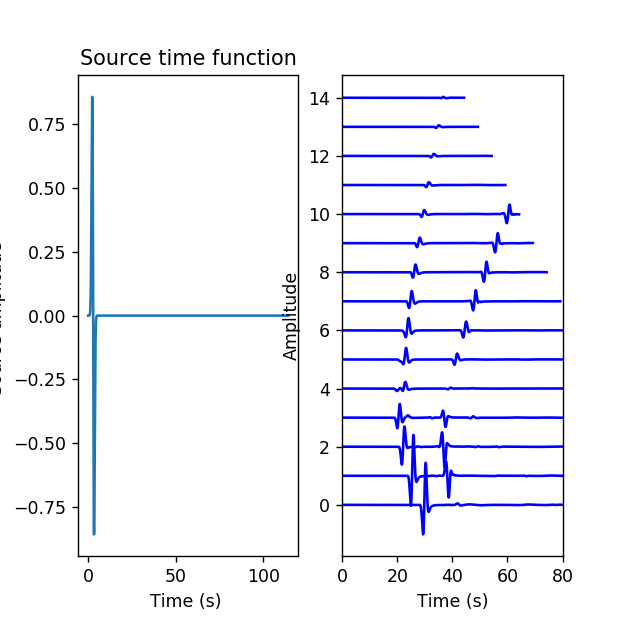

In [20]:
plt.show()